# Week 3: Fitting

In many different cases, we might have a model for how a system works, and want to fit that model to a set of observations. 

We're going to investigate the process of fitting using a classic paper that proposed a model for the [T cell receptor](https://www.ncbi.nlm.nih.gov/pubmed/11606269). Here, the authors develop a mathematical model for how binding occurs and then have observations of how much binding occurs under specific conditions. Identifying whether and how this model fits has led to a better understanding of how our immune system utilizes antibodes, and efforts to design antibodies that function more potently.

In [17]:
% matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import scipy as sp
import scipy.optimize as scopt
np.seterr(over='raise') # sets how floating point errors are handled

def StoneMod(Rtot, Kd, v, Kx, L0):
    '''
    Returns the number of mutlivalent ligand bound to a cell with Rtot
    receptors, granted each epitope of the ligand binds to the receptor
    kind in question with dissociation constant Kd and cross-links with
    other receptors with crosslinking constant Kx. All eq derived from Stone et al. (2001).
    '''
    v = np.int_(v)
    
    # Mass balance for receptor species, to identify the amount of free receptor
    #print('For StoneMod ORIGINAL FUNCTION: \n Rtot is {}, Kd is {}, v is {}, Kx is {}, L0 is {}'.format(Rtot, Kd, v, Kx, L0))
    diffFunAnon = lambda x: Rtot-x*(1+v*L0*(1/Kd)*(1+Kx*x)**(v-1))
    
    # Check that there is a solution
    if (diffFunAnon(0) * diffFunAnon(Rtot)) > 0:
        raise RuntimeError("There is no solution with these parameters. Are your inputs correct?")

    # Vector of binomial coefficients
    Req = scopt.brentq(diffFunAnon, 0, Rtot, disp=False)

    # Calculate vieq from equation 1
    vieq = L0*(1/Kd)*Req*(sp.special.binom(v, np.arange(1, v + 1))) * np.power(Kx*Req, np.arange(v))

    # Calculate L, according to equation 7
    Lbound = np.sum(vieq)

    # Calculate Rmulti from equation 5
    Rmulti = np.sum(np.multiply(vieq[1:], np.arange(2, v + 1, dtype=np.float)))

    # Calculate Rbound
    Rbnd = np.sum(np.multiply(vieq, np.arange(1, v + 1, dtype=np.float)))

    # Calculate numXlinks from equation 4
    nXlink = np.sum(np.multiply(vieq[1:], np.arange(1, v, dtype=np.float)))

    return (Lbound, Rbnd, Rmulti, nXlink)

#data = np.loadtxt("./data/wk3-stone.csv", delimiter=",")

# Vector of the ligand concentrations, cell response (proportional to Rmulti), valencies
# Xs, Ys, Vs = np.hsplit(data, 3)
# Xs, Ys, Vs = np.squeeze(Xs), np.squeeze(Ys), np.squeeze(Vs)

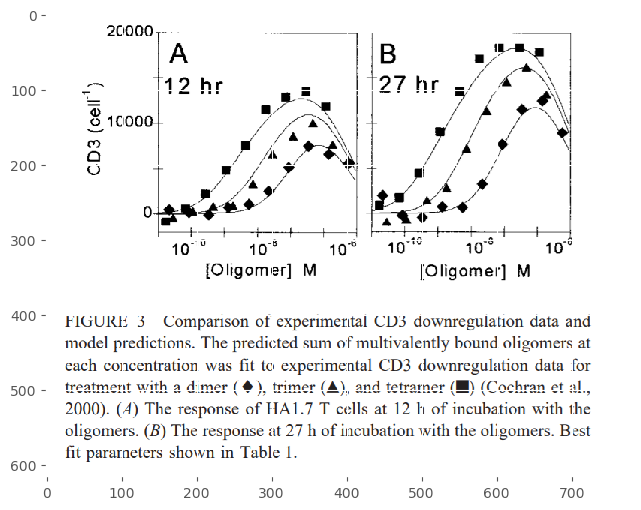

In [18]:
import matplotlib.image as mpimg

fig3 = mpimg.imread('images/fig3_1.PNG')
plt.figure(3, figsize=(7.5, 7.5), dpi=100)
plt.imshow(fig3)
plt.show()

#### (1) We will fit the data contained within Fig. 3B. Plot this data and describe the relationship you see between Kx, Kd, and valency.

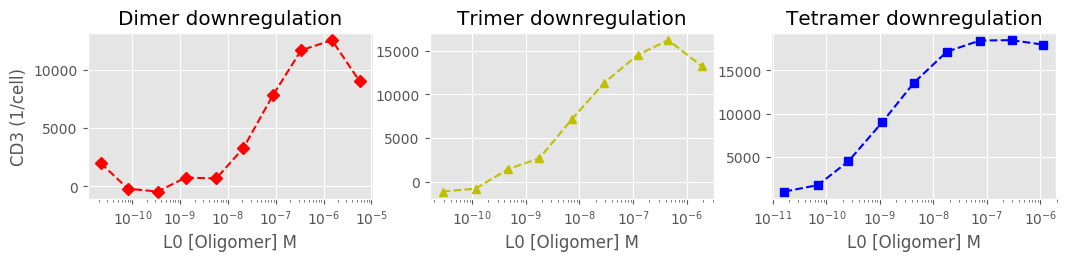

In [19]:
# only plotting

import csv

dimerlist = []
trimerlist = []
tetramerlist = []

csv_reader = csv.reader(open('data\wk3-stone.csv'))
for row in csv_reader:
    if row[2] == '2':
        dimerlist.append(row)
    if row[2] == '3':
        trimerlist.append(row)
    if row[2] == '4':
        tetramerlist.append(row)


dimerlistx, dimerlisty, dimerv = zip(*dimerlist)
trimerlistx, trimerlisty, trimerv = zip(*trimerlist)
tetramerlistx, tetramerlisty, tetramerv = zip(*tetramerlist)

dimerlistx = [float(x) for x in dimerlistx]
dimerlisty = [int(y) for y in dimerlisty]
dimerv = [int(z) for z in dimerv]
trimerlistx = [float(p) for p in trimerlistx]
trimerlisty = [int(q) for q in trimerlisty]
trimerv = [int(r) for r in trimerv]
tetramerlistx = [float(a) for a in tetramerlistx]
tetramerlisty = [int(b) for b in tetramerlisty]
tetramerv = [int(c) for c in tetramerv]

plt.figure(4, figsize=(12.5, 7.5), dpi=100)

plt.subplot(331)
plt.plot(dimerlistx, dimerlisty, 'rD--')
plt.ylabel("CD3 (1/cell)") # same y-label for all graphs
plt.xlabel('L0 [Oligomer] M')
plt.title('Dimer downregulation')
plt.xscale('log')

plt.subplot(332)
plt.plot(trimerlistx, trimerlisty, 'y^--')
plt.xlabel('L0 [Oligomer] M')
plt.title('Trimer downregulation')
plt.xscale('log')

plt.subplot(333)
plt.plot(tetramerlistx, tetramerlisty, 'bs--')
plt.xlabel('L0 [Oligomer] M')
plt.title('Tetramer downregulation')
plt.xscale('log')

plt.show()

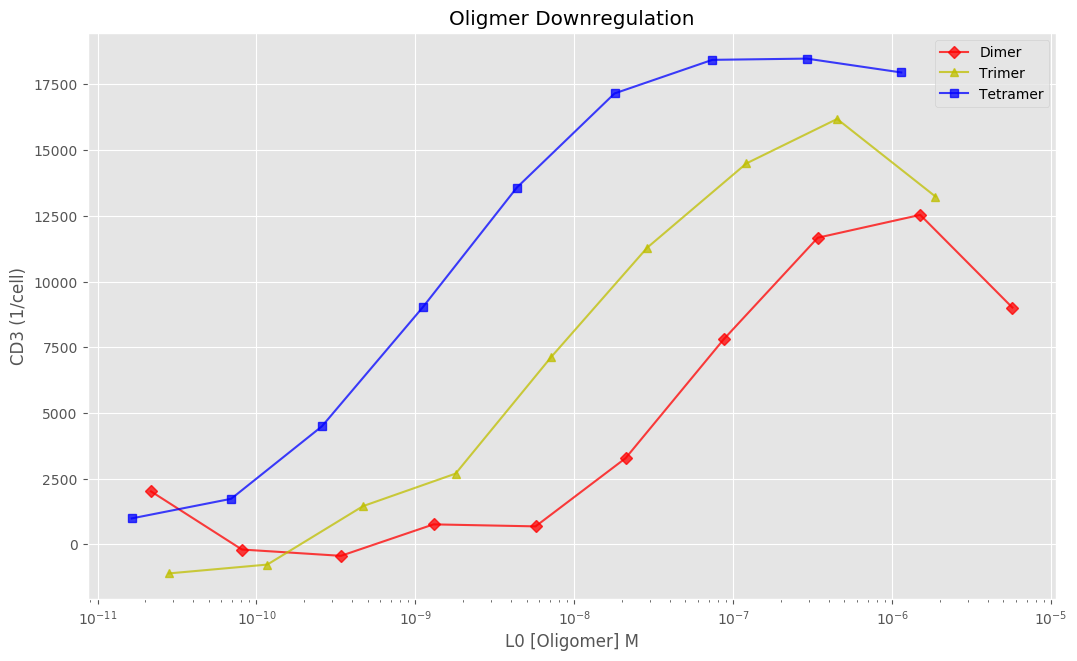

In [20]:
plt.figure(5, figsize=(12.5, 7.5), dpi=100)

plt.plot(dimerlistx, dimerlisty, 'rD-', alpha=0.75, label='Dimer')

plt.plot(trimerlistx, trimerlisty, 'y^-', alpha=0.75, label='Trimer')

plt.plot(tetramerlistx, tetramerlisty, 'bs-', alpha=0.75, label='Tetramer')

plt.xlabel('L0 [Oligomer] M')
plt.ylabel('CD3 (1/cell)')
plt.legend()
plt.title('Oligmer Downregulation')
plt.xscale('log')

plt.show()

Increases in valency (by integer amounts [2,3,4]) shift the CD3 upward and slightly to the left.
Increasing concentration of oligomers increases CD3, but decreases at higher concentrations.
We know from BE 100 and BE 110, that lower Kd implies tighter binding, so decreased Kd means that we have higher CD3.
Kx is akin to how well the ligand changes receptors when binding, but a small enough Kx still implies that the ligand is bound, to the cell, but zipping around to other receptors on the cell

#### (2) First, to fit our model to data, we'll need a function that takes the model predictions, scales them to the units of the actual measurements, and finds the predictions for each condition. Define a scaling parameter and a function that takes it along with the other parameters to make predictions about the experiment.

Use the fit parameters shown in Table 1 (row 2) and overlay with the measurements to ensure your function is working. (Scale = 1 for now.)

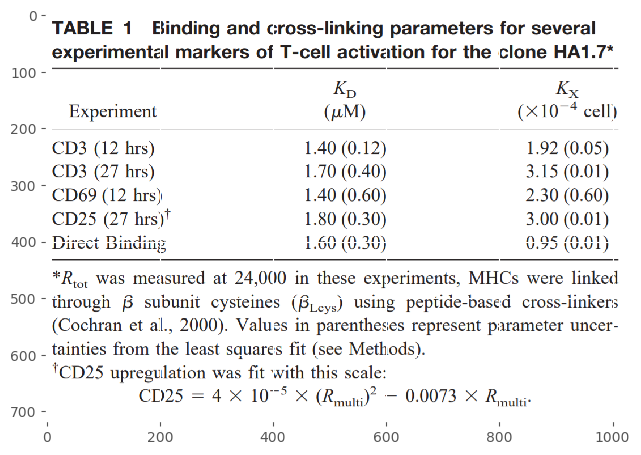

In [21]:
table_1 = mpimg.imread('images/table1_1.PNG')
plt.figure(6, figsize=(7.5, 7.5), dpi=100)
plt.imshow(table_1)
plt.show()

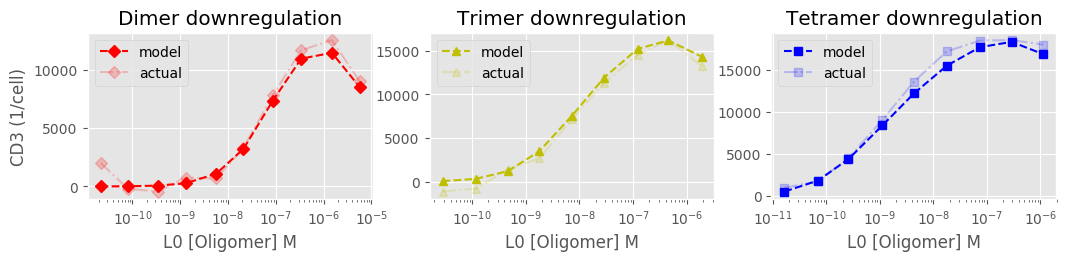

In [22]:
Rtot = 24000

def StoneModScalerRMulti(model_parameters, input_values):
    #print('For StoneModScalerRMulti FUNCTION: \nRtot is {},'.format(Rtot)) 
    #print('Kd is {},'.format( model_parameters[0])) 
    #print('v is {},'.format(input_values[0])) 
    #print('Kx is {},'.format(model_parameters[1]))  
    #print('L0 is {},'.format(input_values[1]))  
    #print('scaler is {}.\n'.format(model_parameters[2]))
    return((model_parameters[2]) * StoneMod(Rtot, model_parameters[0], input_values[0], model_parameters[1], input_values[1])[2])

# v is the valency, the number of binding sites that receptors and ligands posess
# L0 is the bulk concentration of oligomer

Kd_CD3_27hrs = 1.70*(10**(-6))
Kx_CD3_27hrs = 3.15*(10**(-4))
scaler0 = 1

model_parameters = [Kd_CD3_27hrs, Kx_CD3_27hrs, scaler0]

dimer_input_values = list(zip(dimerv, dimerlistx))
dimerlisty_model = []
for i in range(len(dimerlistx)):
    dimerlisty_model.append(StoneModScalerRMulti(model_parameters, dimer_input_values[i]))
    
trimer_input_values = list(zip(trimerv, trimerlistx))
trimerlisty_model = []
for i in range(len(trimerlistx)):
    trimerlisty_model.append(StoneModScalerRMulti(model_parameters, trimer_input_values[i]))
    
tetramer_input_values = list(zip(tetramerv, tetramerlistx))
tetramerlisty_model = []
for i in range(len(tetramerlistx)):
    tetramerlisty_model.append(StoneModScalerRMulti(model_parameters, tetramer_input_values[i]))


plt.figure(7, figsize=(12.5, 7.5), dpi=100)

plt.subplot(331)
plt.plot(dimerlistx, dimerlisty_model, 'rD--', label='model')
plt.plot(dimerlistx, dimerlisty, 'rD-.',  alpha=0.2, label='actual')
plt.xlabel('L0 [Oligomer] M')
plt.ylabel("CD3 (1/cell)") # same y-label for all graphs
plt.title('Dimer downregulation')
plt.legend()
plt.xscale('log')

plt.subplot(332)
plt.plot(trimerlistx, trimerlisty_model, 'y^--', label='model')
plt.plot(trimerlistx, trimerlisty, 'y^-.', alpha=0.2, label='actual')
plt.xlabel('L0 [Oligomer] M')
plt.title('Trimer downregulation')
plt.legend()
plt.xscale('log')

plt.subplot(333)
plt.plot(tetramerlistx, tetramerlisty_model, 'bs--', label='model')
plt.plot(tetramerlistx, tetramerlisty, 'bs-.',  alpha=0.2, label='actual')
plt.xlabel('L0 [Oligomer] M')
plt.title('Tetramer downregulation')
plt.legend()
plt.xscale('log')

plt.show()

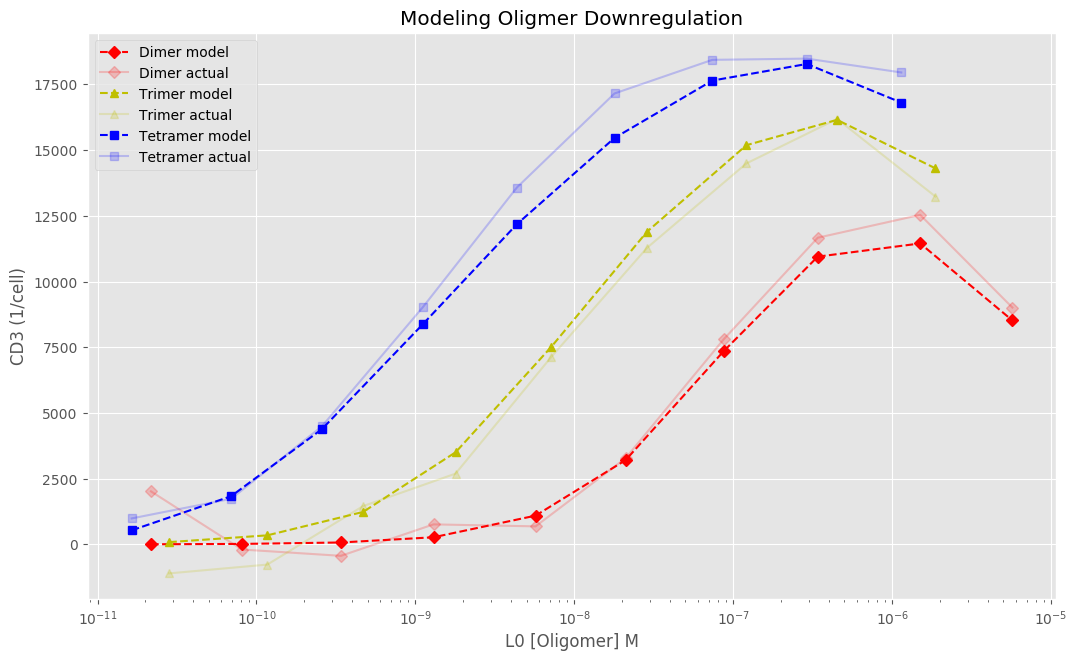

In [23]:
plt.figure(8, figsize=(12.5, 7.5), dpi=100)

plt.plot(dimerlistx, dimerlisty_model, 'rD--', label='Dimer model')
plt.plot(dimerlistx, dimerlisty, 'rD-',  alpha=0.2, label="Dimer actual")

plt.plot(trimerlistx, trimerlisty_model, 'y^--', label='Trimer model')
plt.plot(trimerlistx, trimerlisty, 'y^-', alpha=0.2, label="Trimer actual")

plt.plot(tetramerlistx, tetramerlisty_model, 'bs--', label='Tetramer model')
plt.plot(tetramerlistx, tetramerlisty, 'bs-',  alpha=0.2, label="Tetramer actual")
plt.xscale('log')

plt.xlabel('L0 [Oligomer] M')
plt.ylabel('CD3 (1/cell)')
plt.legend()
plt.title('Modeling Oligmer Downregulation')

plt.show()

#### (2) Now use `scipy.optimize.least_squares` to find the least squares solution.

In [24]:
def residuals_StoneModScalerRMulti(model_parametersq, y_dataq, input_valuesq):
    output_valuesq = []
    for i in range(len(input_valuesq)):
        output_valuesq.append(StoneModScalerRMulti(model_parametersq, input_valuesq[i]))
    
    return([(y_actual - y_predicted) for y_actual, y_predicted in (zip(y_dataq, output_valuesq))])

X0 = [1.70*(10**(-6)), 3.15*(10**(-4)), 1]

merged_input_values = dimer_input_values + trimer_input_values + trimer_input_values
merged_y_actuals = dimerlisty + trimerlisty + tetramerlisty

lstsqr_solution1 = scopt.least_squares(residuals_StoneModScalerRMulti, X0, args=(merged_y_actuals, merged_input_values), bounds = (0, 10000))

print(lstsqr_solution1)

 active_mask: array([0, 0, 0])
        cost: 50309243.350366518
         fun: array([ 2008.69409087,  -223.21998741,  -549.33445438,   340.156382  ,
        -950.44653667, -1127.3006189 , -1168.57774912,  -699.55859695,
        -192.00846572,  -892.5655374 , -1297.86911913, -1518.59702049,
        -949.58510513, -2951.28622962, -2820.58425112, -2547.19782371,
       -1949.12973631,  -919.0338138 , -2199.98860867,   794.13088087,
         984.40297951,  2086.41489487,  3370.71377038,  3625.41574888,
        3323.80217629,  1990.87026369,  1377.9661862 ,  2521.01139133])
        grad: array([  6.36600675e+06,   1.51608941e+04,  -1.18553682e+00])
         jac: array([[  4.41649689e+06,  -1.46798086e+04,  -7.58447266e+00],
       [  1.64243352e+07,  -5.45991435e+04,  -2.82578201e+01],
       [  6.78395707e+07,  -2.25644278e+05,  -1.17655624e+02],
       [  2.44781239e+08,  -8.15882484e+05,  -4.36889385e+02],
       [  8.47793552e+08,  -2.85369132e+06,  -1.69780225e+03],
       [  1.7266177

#### (3) Using leave-one-out crossvalidation, does this model predict the data? Plot the measured vs. predicted data.

L2: Leave One Out Cross Validation Prediction Error is [ 4923701.69944957]
L1: Average of Residual Magnitutude Prediction Error is [ 1878.79324597]
L0: Largest Residual Prediction Error is 28

y-Intercept of line of best fit: [ 70.18873925]
Slope of line of best fit: [ 0.98531816]


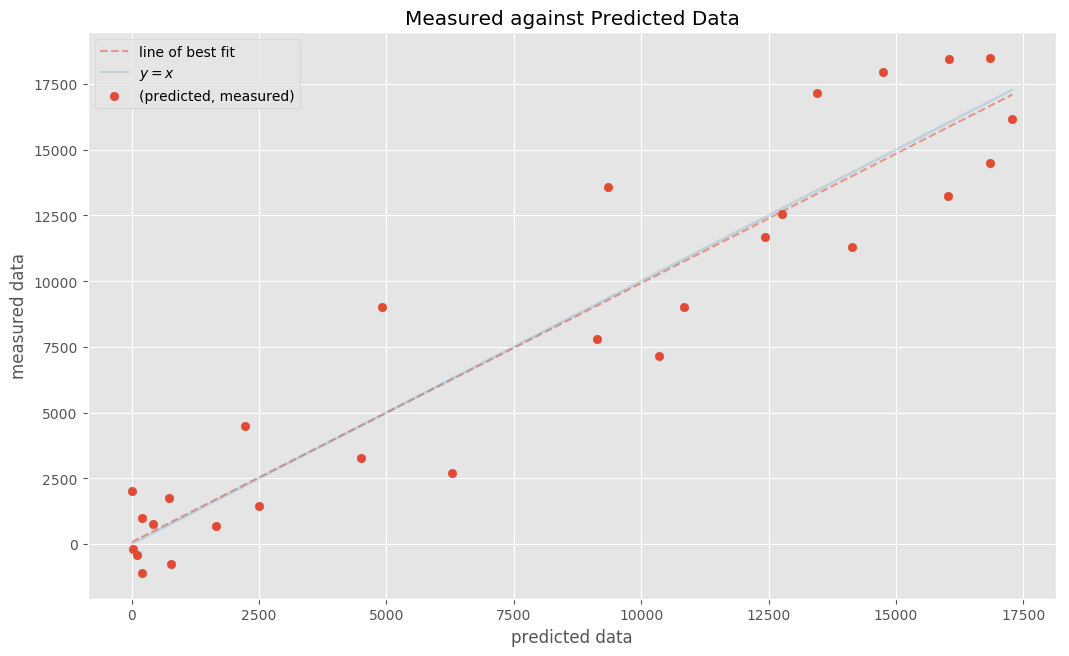

In [25]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

lstsqr_solution_holder = []
listsqrY_predicted_holder = []
Y_test_holder = []
squared_difference_of_Y_test_and_lstsqrY_predicted = []

for train_index, test_index in loo.split(np.array(merged_input_values)):
    X_train, X_test = np.array(merged_input_values)[train_index], np.array(merged_input_values)[test_index]
    Y_train, Y_test = np.array(merged_y_actuals)[train_index], np.array(merged_y_actuals)[test_index]
    lstsqr_solution_holder.append(scopt.least_squares(residuals_StoneModScalerRMulti, X0, args=(Y_train, X_train), bounds = (0, 10000)).x)
    listsqrY_predicted_holder.append(StoneModScalerRMulti(lstsqr_solution_holder[-1], X_test[0]))
    Y_test_holder.append(Y_test)
        
squared_difference_of_Y_test_and_lstsqrY_predicted =  [(y_test-lstsqrY_predicted)**2 for y_test, lstsqrY_predicted in zip(Y_test_holder, listsqrY_predicted_holder)]
normal_difference_of_Y_test_and_lstsqrY_predicted =  [abs(y_test-lstsqrY_predicted) for y_test, lstsqrY_predicted in zip(Y_test_holder, listsqrY_predicted_holder)]

m = len(squared_difference_of_Y_test_and_lstsqrY_predicted)

loocv_prediction_error = sum(squared_difference_of_Y_test_and_lstsqrY_predicted) / m
normal_average_of_abs_residuals = sum(normal_difference_of_Y_test_and_lstsqrY_predicted) / m

print("L2: Leave One Out Cross Validation Prediction Error is {}".format(loocv_prediction_error)) #L2 ish
        
print("L1: Average of Residual Magnitutude Prediction Error is {}".format(normal_average_of_abs_residuals)) #L1 ish

print("L0: Largest Residual Prediction Error is {}".format(np.count_nonzero(normal_difference_of_Y_test_and_lstsqrY_predicted))) #L0 ish

# mini linear regression program i hacked to check my work
# derived values for betas by minimizing residuals
# my work is at https://shak360.github.io/Linear-Regression-in-2-Variables/

x_data = (listsqrY_predicted_holder)
y_data = (Y_test_holder)
    
x_totsum = sum(x_data)
y_totsum = sum(y_data)

x_average = x_totsum / m
y_average = y_totsum / m

xy_data = [(x_data[i] * y_data[i]) for i in range(m)] 

xy_totsum = sum(xy_data)

xx_data = [(x_data[i]*x_data[i]) for i in range(m)]

xx_totsum = sum(xx_data)

xx_average = xx_totsum / m

beta_2 = ((xy_totsum) - (m * x_average * y_average)) / ((xx_totsum) - (m * (x_average)**2))
beta_1 = y_average - (beta_2 * x_average)

print("\ny-Intercept of line of best fit: {}".format(beta_1))
print("Slope of line of best fit: {}".format(beta_2))

# note that beta_2 (slope) is extremely close to 1 that is, 0.98531669 ~ 0.999...
# both nonlinear least squares and leave-one-out-cross-validation did its job well

def linreg(a):
    return (beta_1 + (beta_2 * a))

plt.figure(9, figsize=(12.5, 7.5), dpi=100)
plt.scatter(listsqrY_predicted_holder, Y_test_holder, label='(predicted, measured)')
plt.plot(np.arange(0,max(listsqrY_predicted_holder)), linreg(np.arange(0,max(listsqrY_predicted_holder))), '--', alpha=0.5, label='line of best fit')
plt.plot(listsqrY_predicted_holder, listsqrY_predicted_holder, '-', alpha=0.2, label='$y=x$')
plt.xlabel('predicted data')
plt.ylabel('measured data')
plt.title('Measured against Predicted Data')
plt.legend()
plt.show()

# note also that both the y=x line and the linreg line are right one top of each other

The prediction errors are pretty high but as shown by the line of best fit as well as the $y=x$ line, we see that the predicted data matches pretty well with the observed data. The model _does_ predict the data.

#### (4) Using bootstrap estimation, plot the confidence interval of the model along with the data points.

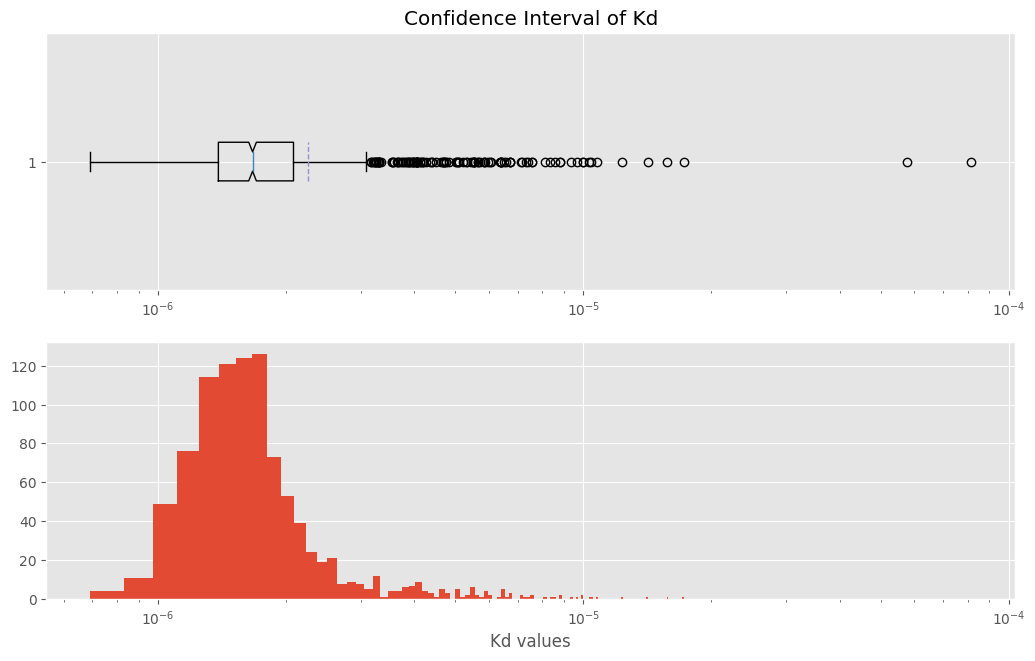

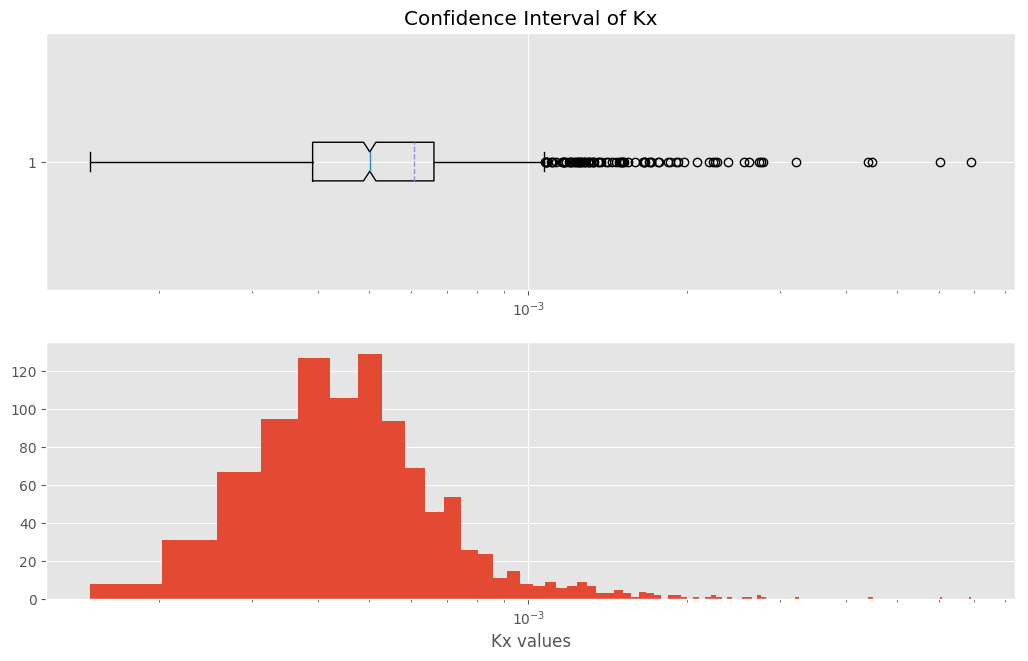

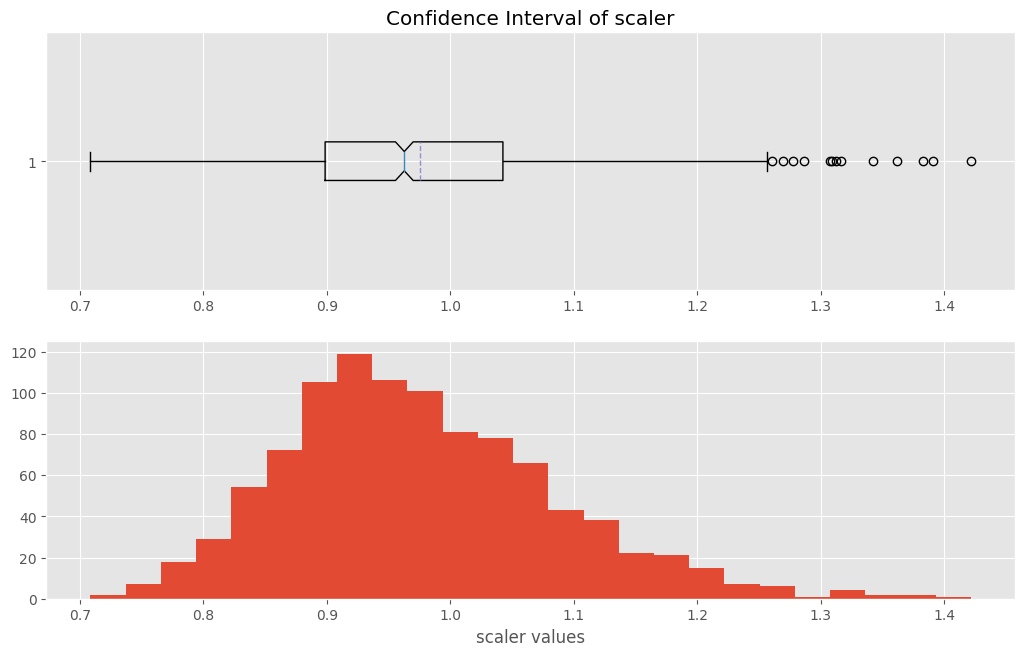

In [26]:
from sklearn.utils import resample

n_iterations = 1000
n_size = m-1

mergedALL = list(zip(merged_input_values, merged_y_actuals))

bs_lstsqr_solution_holder = []
#prediction_error_holder = []


for i in range(n_iterations):
    
    train = resample(mergedALL, n_samples = n_size)
    test = [x for x in mergedALL if x not in train]
    bs_X_train, bs_Y_train = zip(*train)
    bs_X_test, bs_Y_test = zip(*test) 
    bs_lstsqr_solution_holder.append(scopt.least_squares(residuals_StoneModScalerRMulti, X0, args=(bs_Y_train, bs_X_train), bounds = (0, 10000)).x)
    
    count = len(bs_X_test)
    
    bs_listsqrY_predicted_holder = []
    
    #for j in range(count):
    #    bs_listsqrY_predicted_holder.append(StoneModScalerRMulti(bs_lstsqr_solution_holder[-1], bs_X_test[j]))
        
    #bs_Y_test_holder = []
    #for k in range(count):
    #    bs_Y_test_holder.append(bs_Y_test[k])
        
    #prediction_error_holder.append(sum([(y_test-lstsqrY_predicted)**2 for y_test, lstsqrY_predicted in zip(bs_Y_test_holder, bs_listsqrY_predicted_holder)])/(count))

bslist_of_Kd, bslist_of_Kx, bslist_of_scalers = zip(*bs_lstsqr_solution_holder)
    

plt.figure(10, figsize=(12.5, 7.5), dpi=100)

plt.subplot(211)
plt.boxplot(bslist_of_Kd, notch=True, showmeans=True, meanline=True, vert=False)
plt.title('Confidence Interval of Kd')
plt.xscale('log')

plt.subplot(212)
plt.hist(bslist_of_Kd, bins='auto')
plt.xscale('log')
plt.xlabel("Kd values")

plt.show()

plt.figure(11, figsize=(12.5, 7.5), dpi=100)

plt.subplot(211)
plt.boxplot(bslist_of_Kx, notch=True, showmeans=True, meanline=True, vert=False)

plt.xscale('log')
plt.title('Confidence Interval of Kx')

plt.subplot(212)
plt.hist(bslist_of_Kx, bins='auto')
plt.xscale('log')
plt.xlabel("Kx values")

plt.show()

plt.figure(12, figsize=(12.5, 7.5), dpi=100)

plt.subplot(211)
plt.boxplot(bslist_of_scalers, notch=True, showmeans=True, meanline=True, vert=False)

plt.title('Confidence Interval of scaler')

plt.subplot(212)
plt.hist(bslist_of_scalers, bins='auto')
plt.xlabel("scaler values")

plt.show()

#plt.figure(13, figsize=(12.5, 7.5), dpi=100)

#plt.subplot(211)
#plt.boxplot(prediction_error_holder, notch=True, showmeans=True, meanline=True, vert=False)

#plt.subplot(212)
#plt.hist(prediction_error_holder,  bins='auto')

#plt.show()

#### (5) Now, we will perform a local sensitivity analysis to look at the dependence of the model results on each parameter. Vary each parameter up and down by 10-fold **while holding the others constant**, and plot the sum of squared error.

Which parameter influences the fit the most? Which one the least?

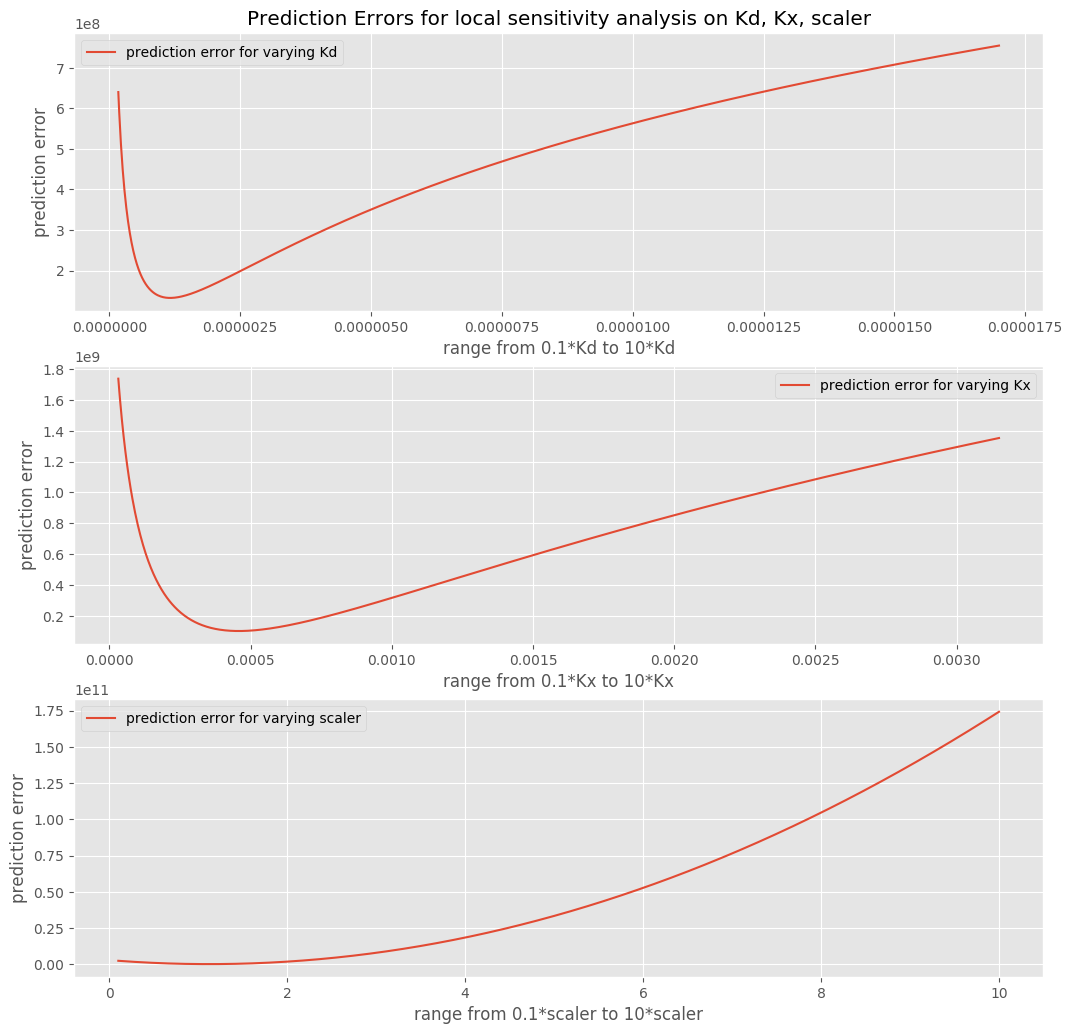

In [27]:
Kd_vary = np.linspace(start=0.1*Kd_CD3_27hrs, stop=10*Kd_CD3_27hrs, num=1000)
Kx_vary = np.linspace(start=0.1*Kx_CD3_27hrs, stop=10*Kx_CD3_27hrs, num=1000)
scaler_vary = np.linspace(start=0.1*scaler0, stop=10*scaler0, num=1000)

model_parameters_Kd_varying = []
model_parameters_Kx_varying = []
model_parameters_scaler_varying = []

sum_Kd_sqrd_diff_holder = []
sum_Kx_sqrd_diff_holder = []
sum_scaler_sqrd_diff_holder = []

for i in range(1000):
    model_parameters_Kd_varying.append([Kd_vary[i], Kx_CD3_27hrs, scaler0])
    model_parameters_Kx_varying.append([Kd_CD3_27hrs, Kx_vary[i], scaler0])
    model_parameters_scaler_varying.append([Kd_CD3_27hrs, Kx_CD3_27hrs, scaler_vary[i]])
    
    Kd_varying_y_model = []
    Kd_sqrd_diff_holder = []
    Kx_varying_y_model = []
    Kx_sqrd_diff_holder = []
    scaler_varying_y_model = []
    scaler_sqrd_diff_holder = []
    
    for i in range(len(merged_input_values)):
        Kd_varying_y_model.append(StoneModScalerRMulti(model_parameters_Kd_varying[-1], merged_input_values[i]))
        Kd_sqrd_diff_holder.append((merged_y_actuals[i]-Kd_varying_y_model[i])**2)
        
        Kx_varying_y_model.append(StoneModScalerRMulti(model_parameters_Kx_varying[-1], merged_input_values[i]))
        Kx_sqrd_diff_holder.append((merged_y_actuals[i]-Kx_varying_y_model[i])**2)
        
        scaler_varying_y_model.append(StoneModScalerRMulti(model_parameters_scaler_varying[-1], merged_input_values[i]))
        scaler_sqrd_diff_holder.append((merged_y_actuals[i]-scaler_varying_y_model[i])**2)
        
    sum_Kd_sqrd_diff_holder.append(sum(Kd_sqrd_diff_holder))
    sum_Kx_sqrd_diff_holder.append(sum(Kx_sqrd_diff_holder))
    sum_scaler_sqrd_diff_holder.append(sum(scaler_sqrd_diff_holder))

    
plt.figure(13, figsize=(12.5, 12.5), dpi=100)

plt.subplot(311)
plt.plot(Kd_vary, sum_Kd_sqrd_diff_holder, label='prediction error for varying Kd')
plt.title('Prediction Errors for local sensitivity analysis on Kd, Kx, scaler')
plt.xlabel('range from 0.1*Kd to 10*Kd')
plt.ylabel('prediction error')
plt.legend()


plt.subplot(312)
plt.plot(Kx_vary, sum_Kx_sqrd_diff_holder, label='prediction error for varying Kx')
plt.ylabel('prediction error')
plt.xlabel('range from 0.1*Kx to 10*Kx')
plt.legend()


plt.subplot(313)
plt.plot(scaler_vary, sum_scaler_sqrd_diff_holder, label='prediction error for varying scaler')
plt.ylabel('prediction error')
plt.xlabel('range from 0.1*scaler to 10*scaler')
plt.legend()

plt.show()

We can see that varying the scaler creates the largest error in the model, about $1.75\textrm{e}11$, while varying Kx, creates a medium amount of error, not far off from about $1\textrm{e}8$, about the maximum error produced by varying Kd, but the lowest error amongst the three parameters. We also see that the shape of the error created by both Kd and Kx are extremely similar, while the scaler error curve resembles neither of the above. The scaler parameter influences the fit the most, while the Kd parameter influences the fit the least.

#### (6) While easier to perform, a local sensitivity analysis ignores co-dependency between the parameters. Do you anticipate your predictions of the parameter values will be more or less specified with a global analysis?

It seems like the Kd and Kx values are codependent since their errors follow the same shape, while the scaler is independent of the other two values. If they are codependent, we can say that the parameter values of Kd and Kx will be more specified, as in their confidence intervals are smaller, and the error will decrease as they vary together.

#### (7) Now, vary each parameter from the optimal solution, *allowing the other parameters to vary*. Was your prediction true? How might the other parameters be varying when Kd increases?

Hint: The easiest way to do this is mess with the bounds of the least squares solver to hold your parameter of interest within a small range.

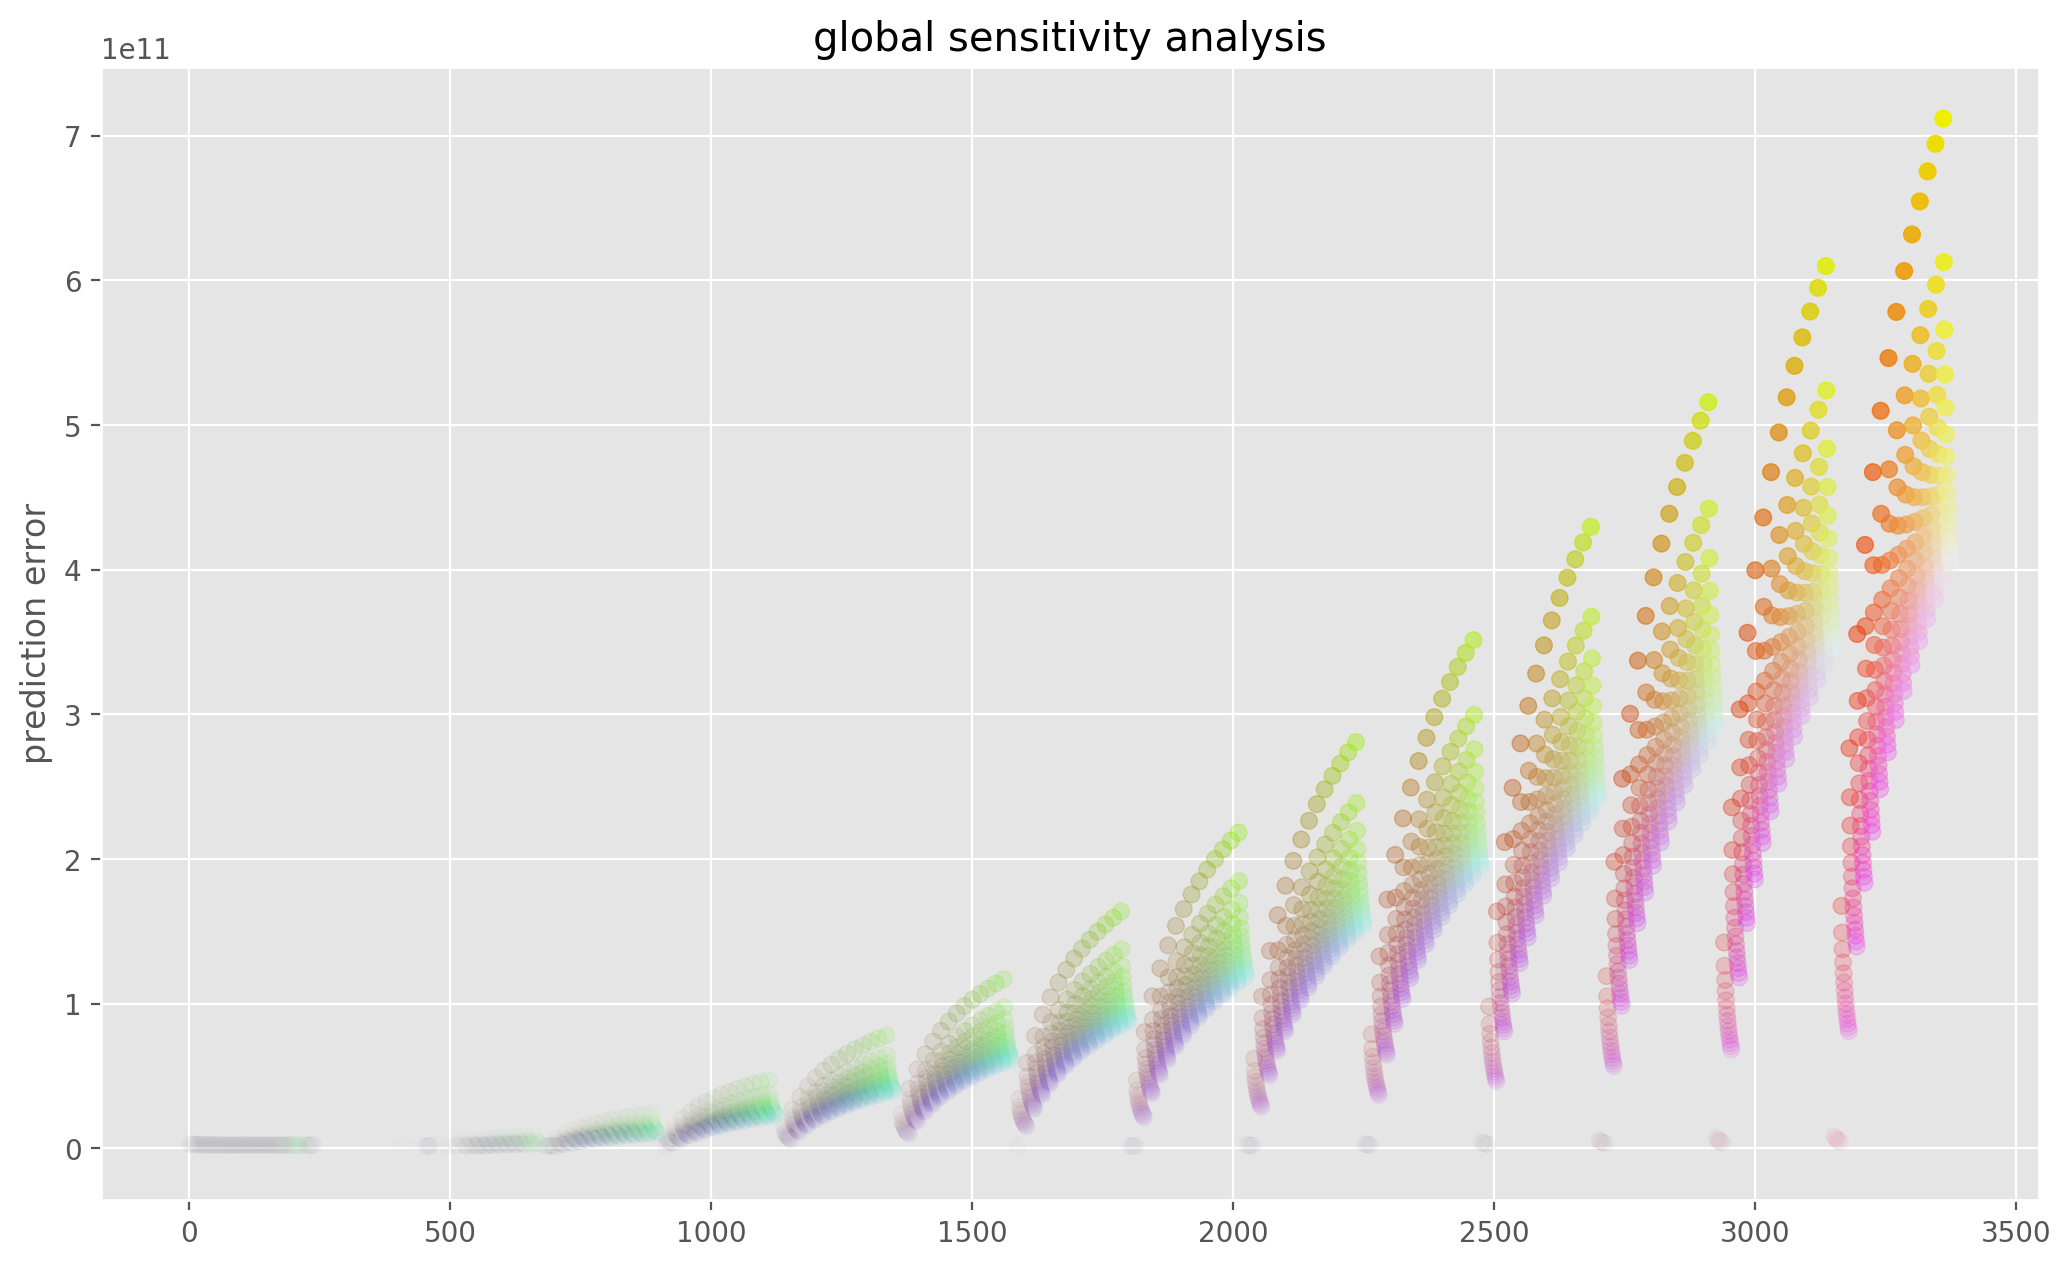

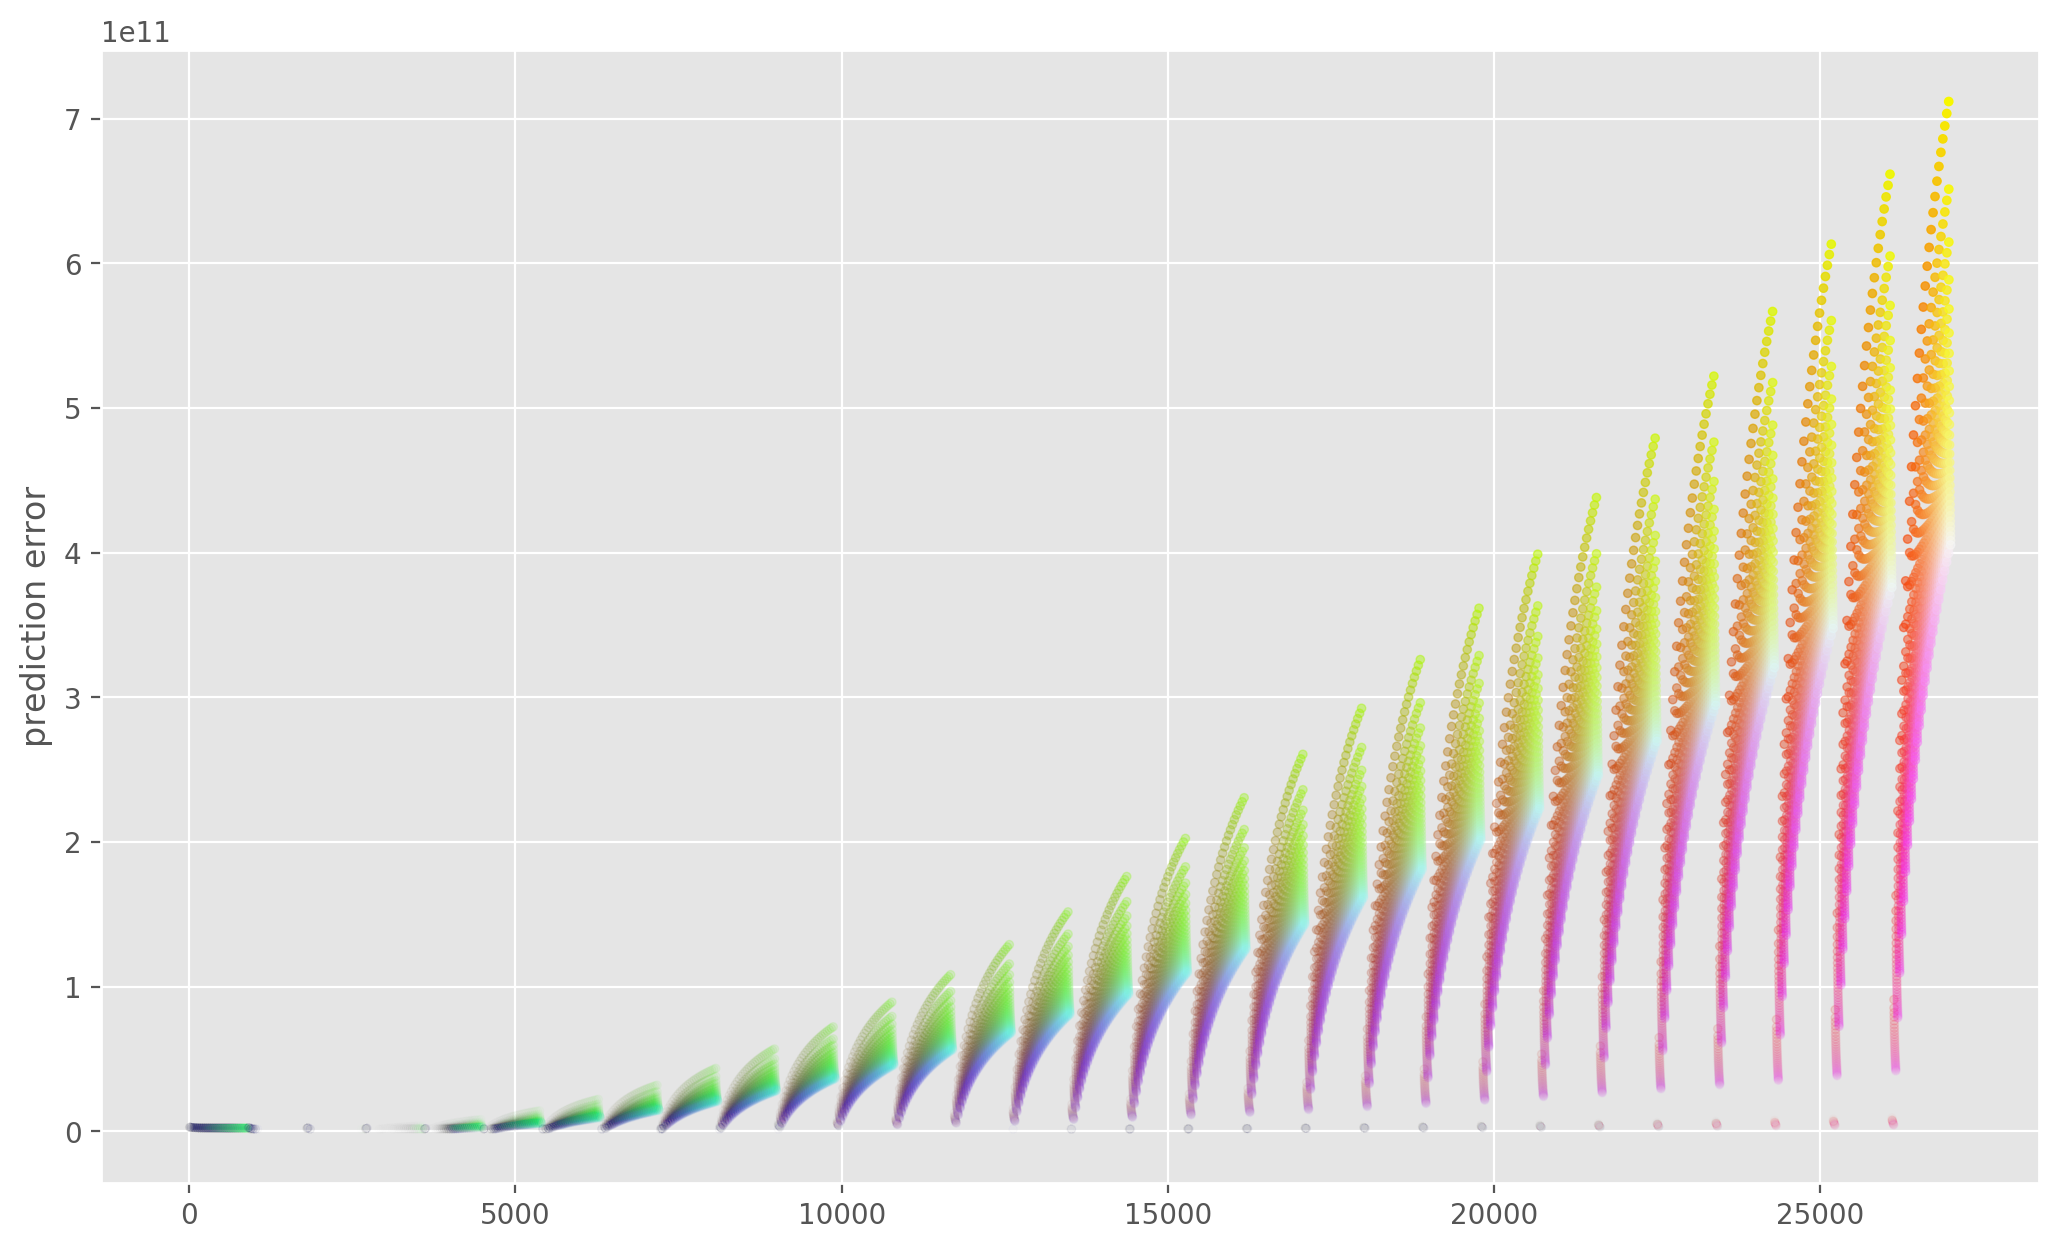

In [28]:
import matplotlib.cm as cm

def global_sensitivity_analyzer(runner):
    Kd_vary_runner = np.linspace(start=0.1*Kd_CD3_27hrs, stop=10*Kd_CD3_27hrs, num=runner)
    Kx_vary_runner = np.linspace(start=0.1*Kx_CD3_27hrs, stop=10*Kx_CD3_27hrs, num=runner)
    scaler_vary_runner = np.linspace(start=0.1*scaler0, stop=10*scaler0, num=runner)

    model_parameters_all_varying = []

    sum_all_sqrd_diff_holder = []
    color_array = []

    for r in range(runner):
        for g in range(runner):
            for b in range(runner):

                model_parameters_all_varying.append([Kd_vary_runner[b], Kx_vary_runner[g], scaler_vary_runner[r]])
                color_array.append([r/runner,g/runner,b/runner]) 


                all_varying_y_model = []
                all_sqrd_diff_holder = []

                for i in range(len(merged_input_values)):
                    all_varying_y_model.append(StoneModScalerRMulti(model_parameters_all_varying[-1], merged_input_values[i]))
                    all_sqrd_diff_holder.append((merged_y_actuals[i]-all_varying_y_model[i])**2)

                sum_all_sqrd_diff_holder.append(sum(all_sqrd_diff_holder))


    alpha_values = np.array([y/max(sum_all_sqrd_diff_holder) for y in sum_all_sqrd_diff_holder]) 
    reds, greens, blues = zip(*color_array)

    color_array_with_alpha = list(zip(reds, greens, blues, alpha_values))
    
    return(sum_all_sqrd_diff_holder, color_array_with_alpha)

plt.figure(14, figsize=(12.5, 7.5), dpi=200)
plt.scatter(np.arange(15**3), global_sensitivity_analyzer(15)[0], c = global_sensitivity_analyzer(15)[1])
plt.ylabel('prediction error')
plt.title('global sensitivity analysis')
plt.show()

plt.figure(15, figsize=(12.5, 7.5), dpi=200)
plt.scatter(np.arange(30**3), global_sensitivity_analyzer(30)[0], marker='.', c = global_sensitivity_analyzer(30)[1])
plt.ylabel('prediction error')
plt.show()

Here the range of the scaler, the one that produces the most error, is represented by the spectrum of the red color. The red color is the one that changes the slowest, since it is the outermost for loop iterator. This means that if we can interpret the graph as a "book" where each streak is a page in the book, then each individual page is an increase in the color red. In the beginning we start at the red value low and near the $0.1\times\textrm{scaler}$ region while at the end we are at the $10\times\textrm{scaler}$, a region which produces the most error. This is obvious since the graph has a clear upward trend toward that error. The alpha or transparency values represent the error, at max error we have 'alpha=1' while at minimum error we have 'alpha=0'. The points with the strongest alphas are those that are yellow. Using a color mixer, we can see that the yellow color is a combination of high reds and high greens. Here Kx is represented by the range of green colors. This makes sense since the highest error should be produced by two independent error producing of the highest magnitudes, the highest scaler value and the highest Kx value. Another interesting place to look would be when all values are maximal and minimal, as colors these are white and black. Black is at the beginning of the graph, since the for loops would all start at a 0 index. Even though the scaler value near its $0.1\times\textrm{scaler}$ region produces minimal error, we see from 6 that Kd and Kx produce nontrivial error. At the white region, all values are approaching the $10\times\beta_x$ region. Intutitively, we would think that since all errors are pretty high indivdually, the white point on the graph should be the highest point, but we see that yellow points (high Kx and high scaler) create more error than white (high Kd, high Kx, and high scaler). This could mean that varying Kd and Kx together actually creates less error since they maybe codepend on each other. Another interesting point or set of points to look at are the turquoise (light blue or ocean blue) which is created by equally high Kd and high Kx values that eventully turn white by increasing scaler values (increasing red). These trends can be further analyzed, by assigning different colors to each of the parameters

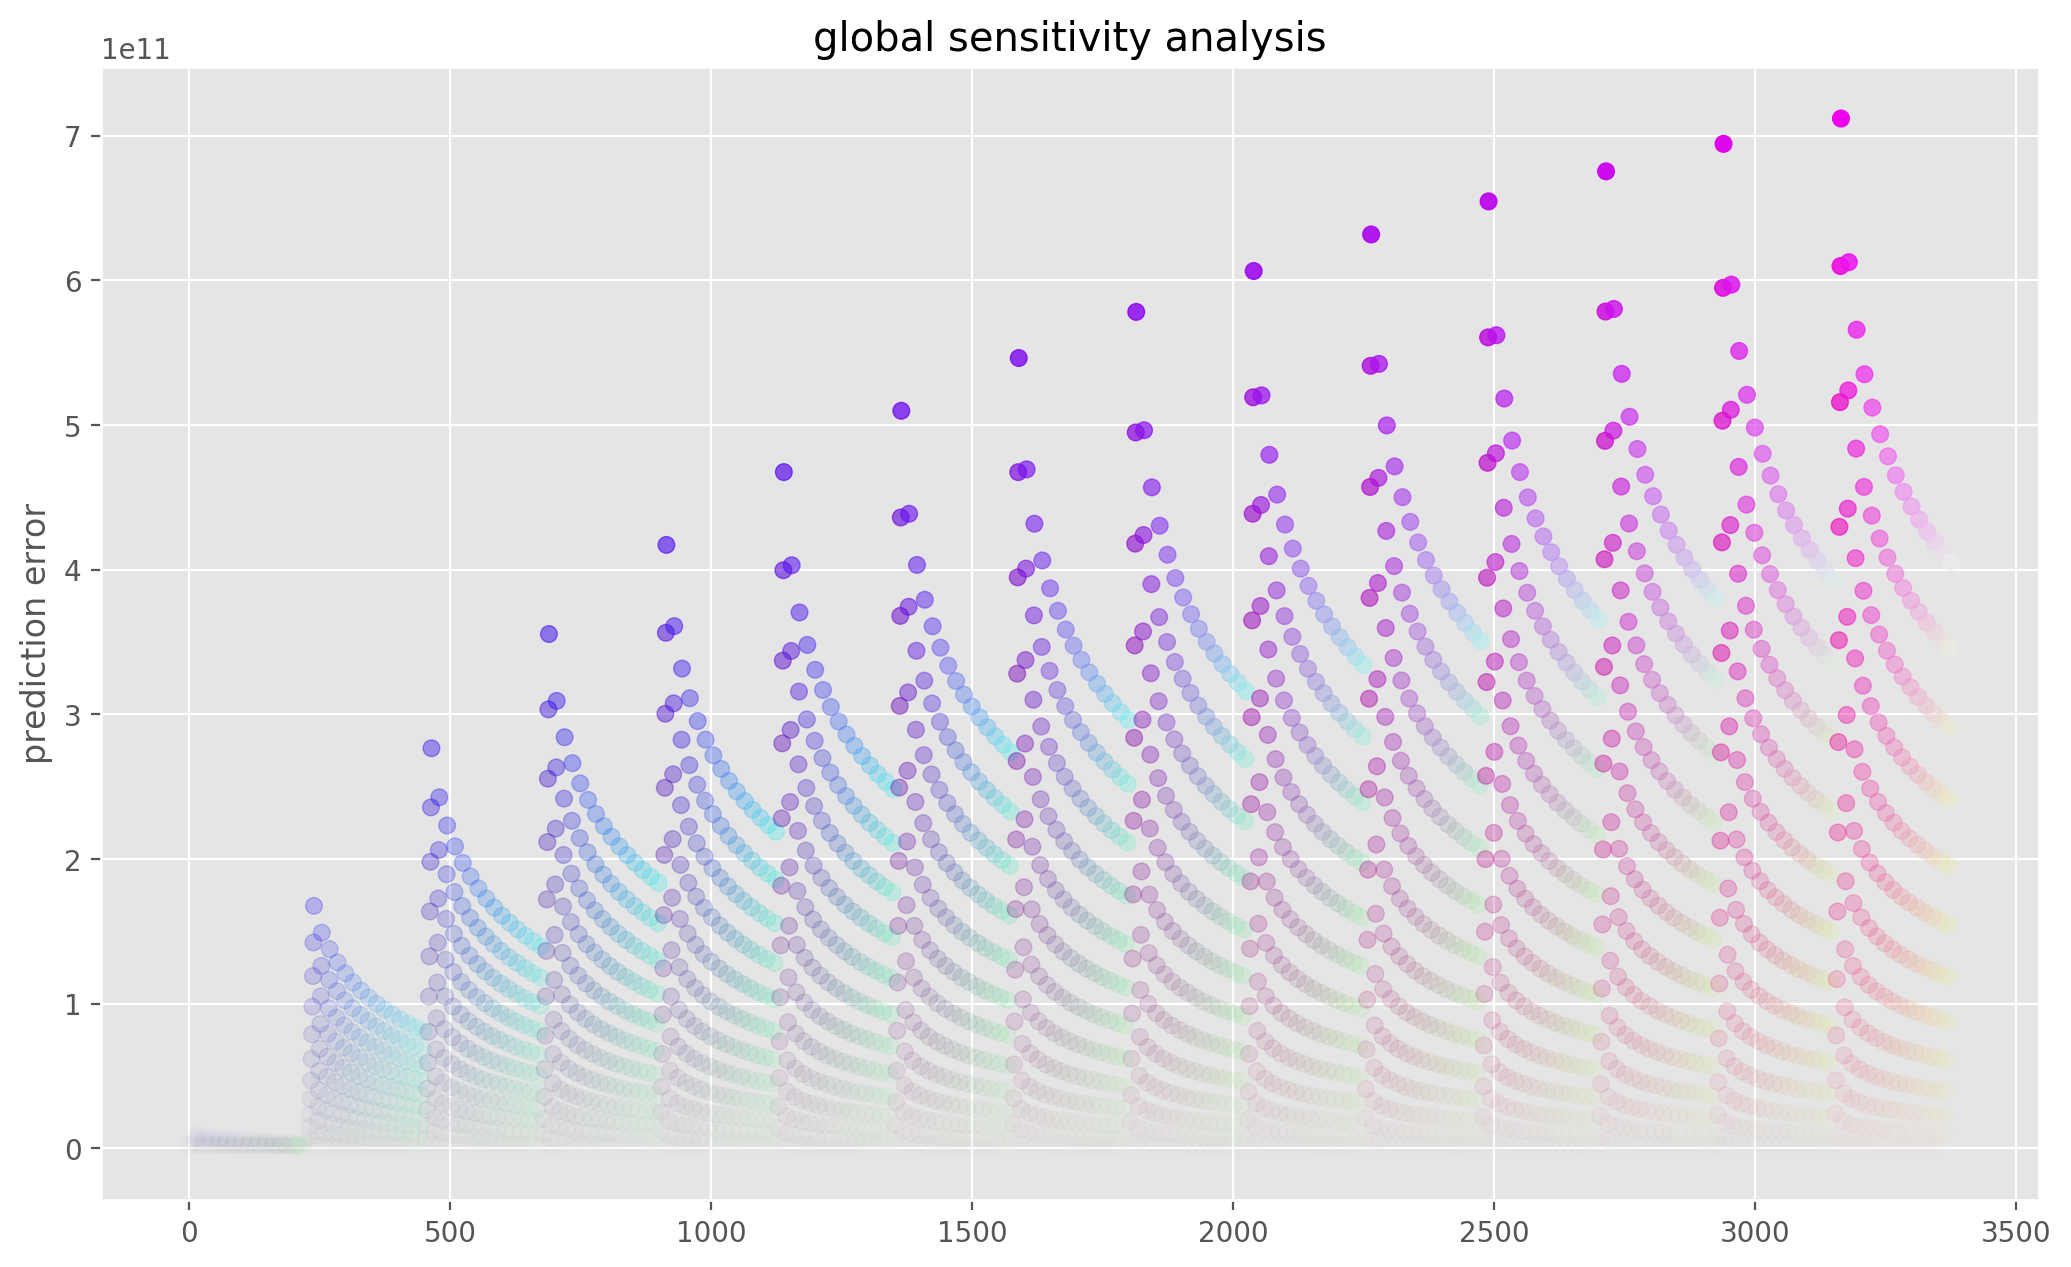

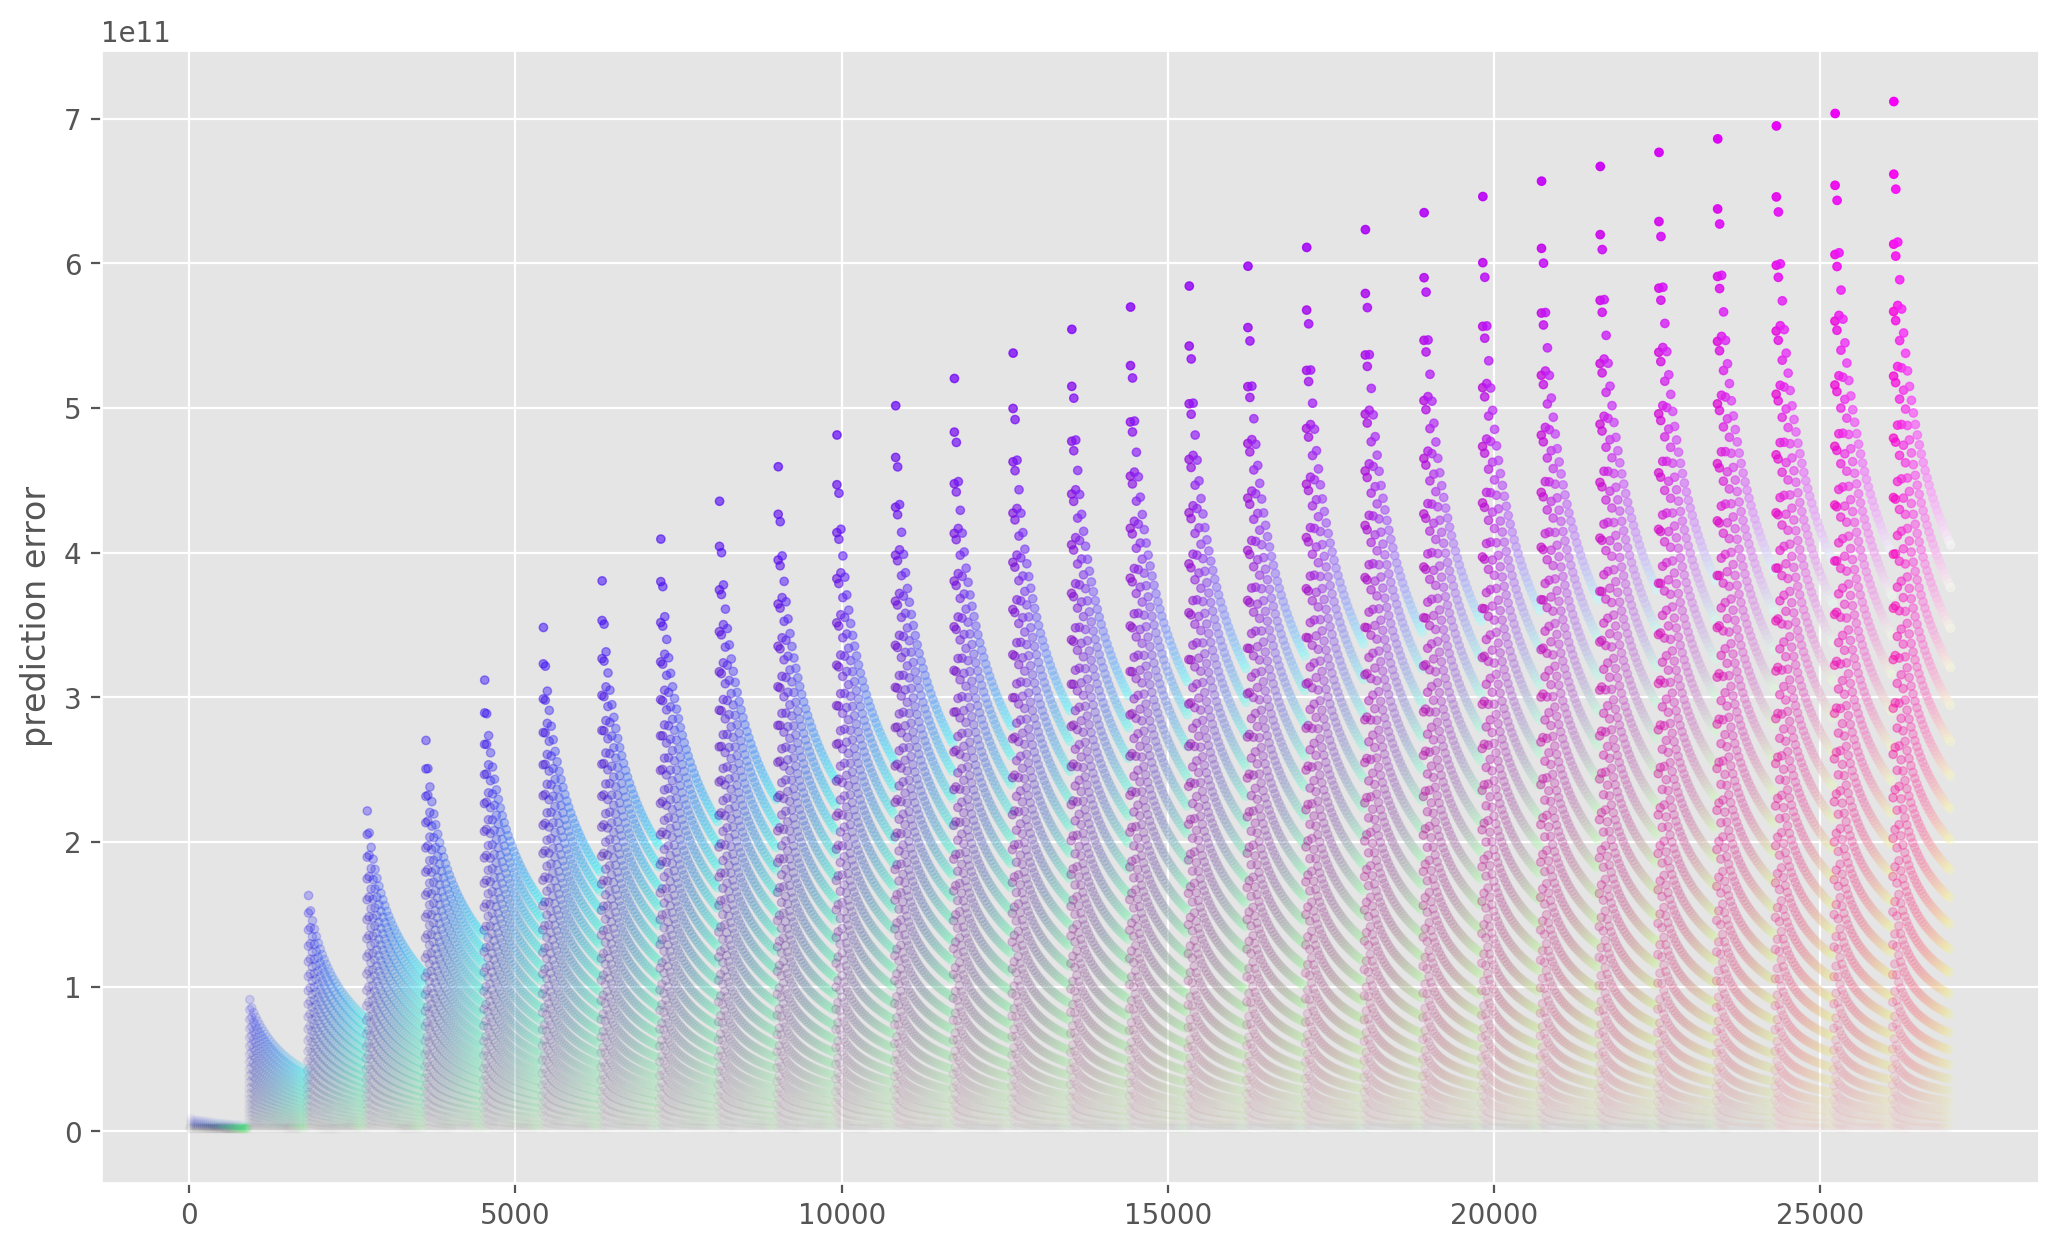

In [29]:
def global_sensitivity_analyzer_diff(runner):
    Kd_vary_runner = np.linspace(start=0.1*Kd_CD3_27hrs, stop=10*Kd_CD3_27hrs, num=runner)
    Kx_vary_runner = np.linspace(start=0.1*Kx_CD3_27hrs, stop=10*Kx_CD3_27hrs, num=runner)
    scaler_vary_runner = np.linspace(start=0.1*scaler0, stop=10*scaler0, num=runner)

    model_parameters_all_varying = []

    sum_all_sqrd_diff_holder = []
    color_array = []

    for r in range(runner):
        for g in range(runner):
            for b in range(runner):

                model_parameters_all_varying.append([Kd_vary_runner[g], Kx_vary_runner[r], scaler_vary_runner[b]])
                color_array.append([r/runner,g/runner,b/runner]) 


                all_varying_y_model = []
                all_sqrd_diff_holder = []

                for i in range(len(merged_input_values)):
                    all_varying_y_model.append(StoneModScalerRMulti(model_parameters_all_varying[-1], merged_input_values[i]))
                    all_sqrd_diff_holder.append((merged_y_actuals[i]-all_varying_y_model[i])**2)

                sum_all_sqrd_diff_holder.append(sum(all_sqrd_diff_holder))


    alpha_values = np.array([y/max(sum_all_sqrd_diff_holder) for y in sum_all_sqrd_diff_holder]) 
    reds, greens, blues = zip(*color_array)

    color_array_with_alpha = list(zip(reds, greens, blues, alpha_values))
    
    return(sum_all_sqrd_diff_holder, color_array_with_alpha)

plt.figure(16, figsize=(12.5, 7.5), dpi=200)
plt.scatter(np.arange(15**3), global_sensitivity_analyzer_diff(15)[0], c = global_sensitivity_analyzer_diff(15)[1])
plt.ylabel('prediction error')
plt.title('global sensitivity analysis')
plt.show()

plt.figure(17, figsize=(12.5, 7.5), dpi=200)
plt.scatter(np.arange(30**3), global_sensitivity_analyzer_diff(30)[0], marker='.', c = global_sensitivity_analyzer_diff(30)[1])
plt.ylabel('prediction error')
plt.show()

Here each page in the book represents an increase red (which is the same as the last analysis, but now representative of increasing Kx from $0.1\times{K_x}$ to $10\times{K_x}$) while running "up" the height of the page of each book represents an increase in blue (scaler values), while runnning "left to right" on each page is an increase in green (Kd values). Since we know that increasing the scaler value creates the most error, we can look at that first. Since each page is given the chance to push scaler to its maximal value (and contribute its maximal error), we get a spiking trend. Each spike tends to decrease before Kx increments again. This means that increasing Kd and increasing scaler have an inverse relationship. Another way to check the accuracy of the graphs is ensure that the white and black points are at the same point and same transparency as each of the other graphs.

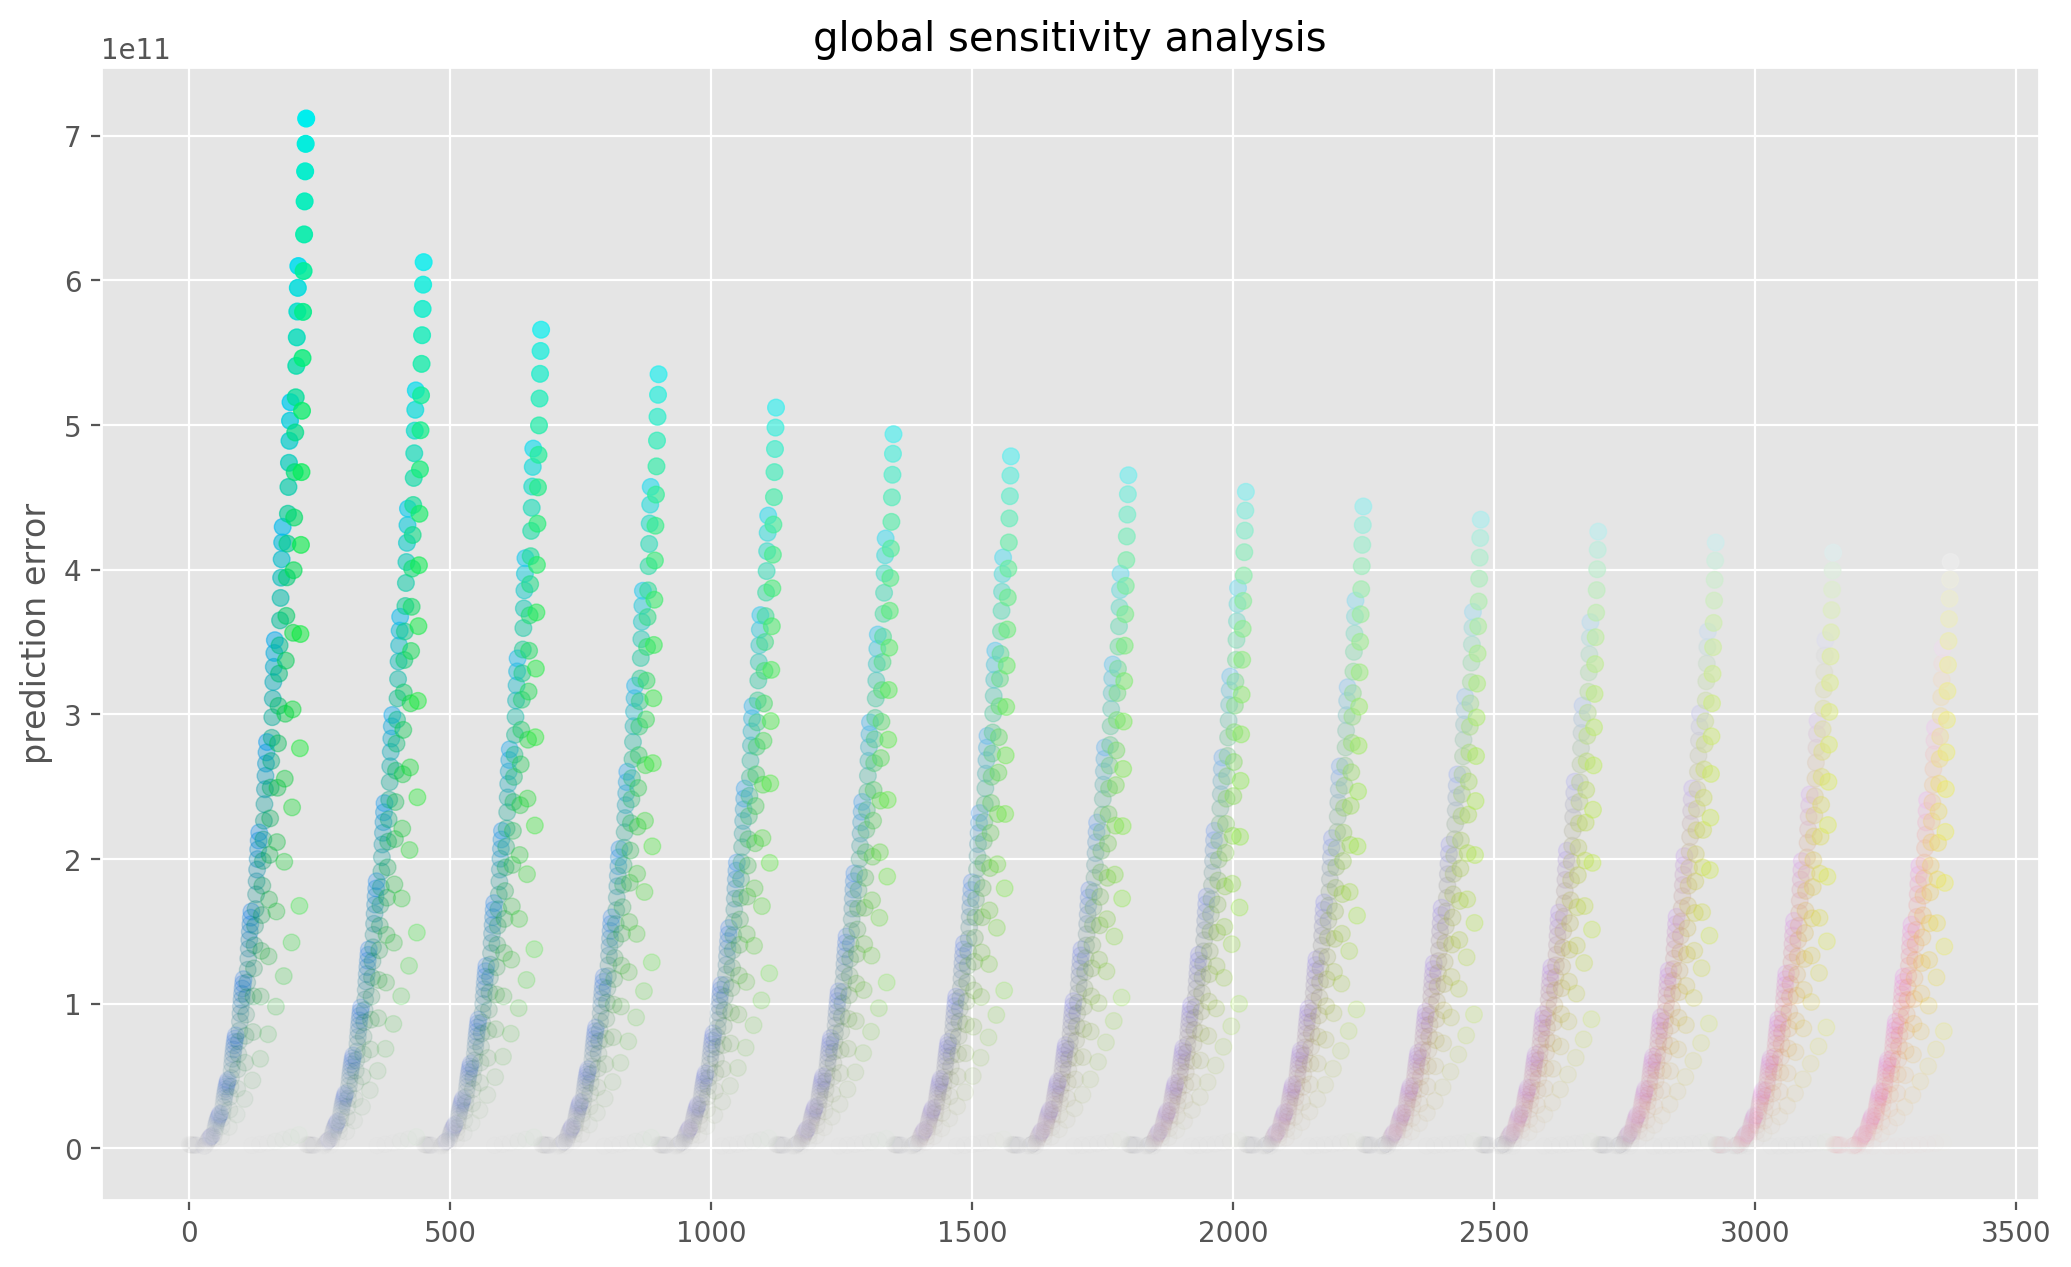

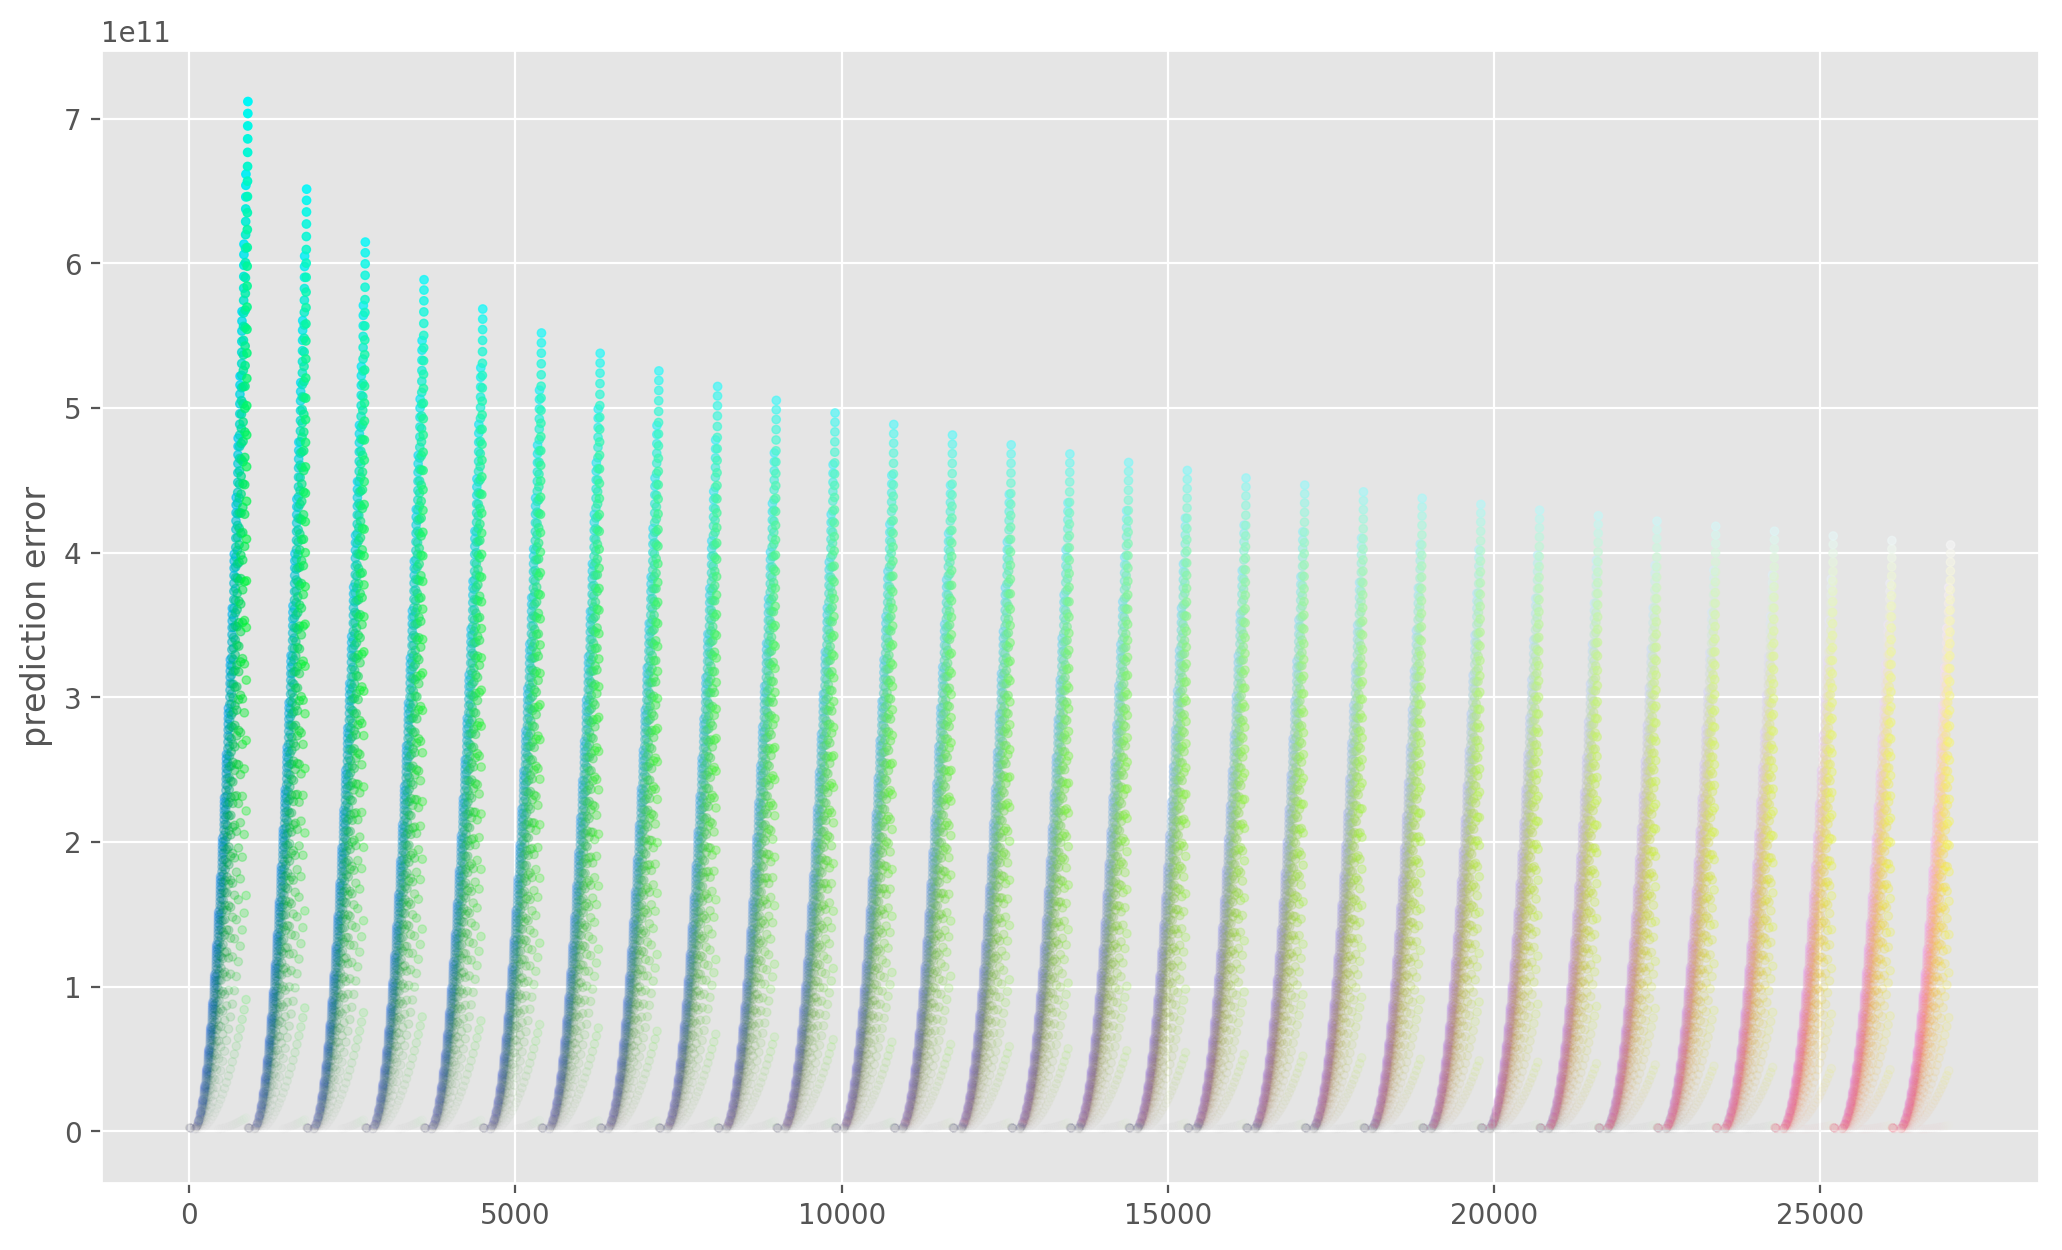

In [30]:
def global_sensitivity_analyzer_diff2(runner):
    Kd_vary_runner = np.linspace(start=0.1*Kd_CD3_27hrs, stop=10*Kd_CD3_27hrs, num=runner)
    Kx_vary_runner = np.linspace(start=0.1*Kx_CD3_27hrs, stop=10*Kx_CD3_27hrs, num=runner)
    scaler_vary_runner = np.linspace(start=0.1*scaler0, stop=10*scaler0, num=runner)

    model_parameters_all_varying = []

    sum_all_sqrd_diff_holder = []
    color_array = []

    for r in range(runner):
        for g in range(runner):
            for b in range(runner):

                model_parameters_all_varying.append([Kd_vary_runner[r], Kx_vary_runner[b], scaler_vary_runner[g]])
                color_array.append([r/runner,g/runner,b/runner]) 


                all_varying_y_model = []
                all_sqrd_diff_holder = []

                for i in range(len(merged_input_values)):
                    all_varying_y_model.append(StoneModScalerRMulti(model_parameters_all_varying[-1], merged_input_values[i]))
                    all_sqrd_diff_holder.append((merged_y_actuals[i]-all_varying_y_model[i])**2)

                sum_all_sqrd_diff_holder.append(sum(all_sqrd_diff_holder))


    alpha_values = np.array([y/max(sum_all_sqrd_diff_holder) for y in sum_all_sqrd_diff_holder]) 
    reds, greens, blues = zip(*color_array)

    color_array_with_alpha = list(zip(reds, greens, blues, alpha_values))
    
    return(sum_all_sqrd_diff_holder, color_array_with_alpha)

plt.figure(18, figsize=(12.5, 7.5), dpi=200)
plt.scatter(np.arange(15**3), global_sensitivity_analyzer_diff2(15)[0], c = global_sensitivity_analyzer_diff2(15)[1])
plt.ylabel('prediction error')
plt.title('global sensitivity analysis')
plt.show()

plt.figure(19, figsize=(12.5, 7.5), dpi=200)
plt.scatter(np.arange(30**3), global_sensitivity_analyzer_diff2(30)[0], marker='.', c = global_sensitivity_analyzer_diff2(30)[1])
plt.ylabel('prediction error')
plt.show()

This is a final iteration of the color trends. Flipping through the pages, increases the red value, and increases the Kd value. Since we established in the first analysis that increasing Kx and scaler values produces the most amount of error, we can ensure that is true by seeing the spiking behaviour of the turquoises. It is interesting to note that increasing Kd values, even near the maximal region decreases the error.

#### (8) At the same time as providing the number of multimerized receptors, the model also infers the quantities of other properties, such as the amount of ligand and receptor bound. Using the bootstrap estimates, plot the confidence in these other parameters. Are these more or less exactly specified than Rmulti? What can you say about which quantities will be most exactly predicted?

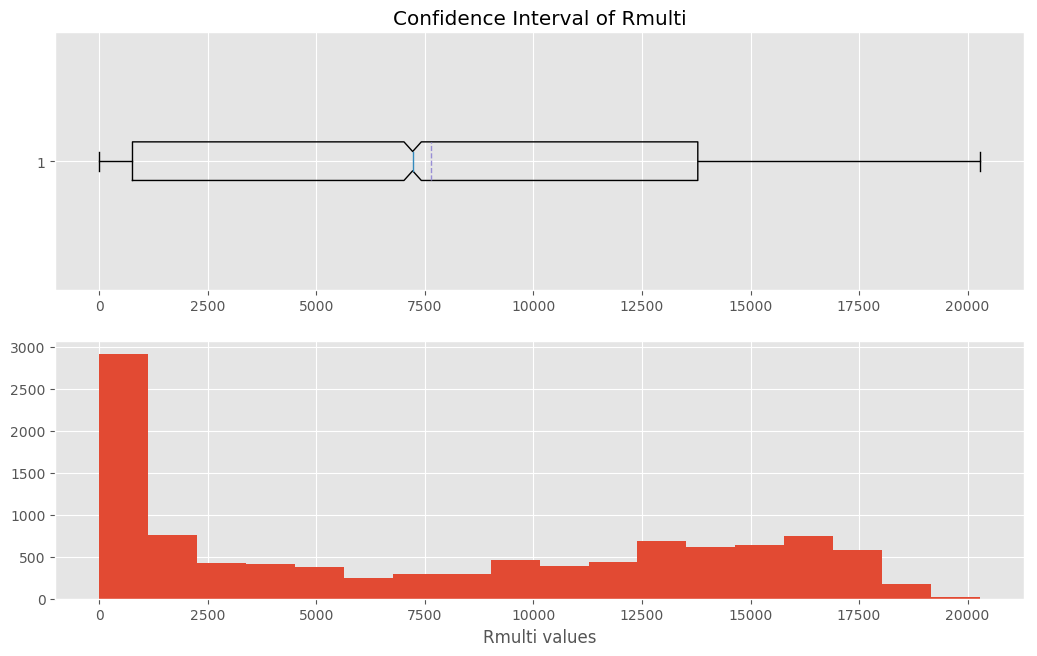

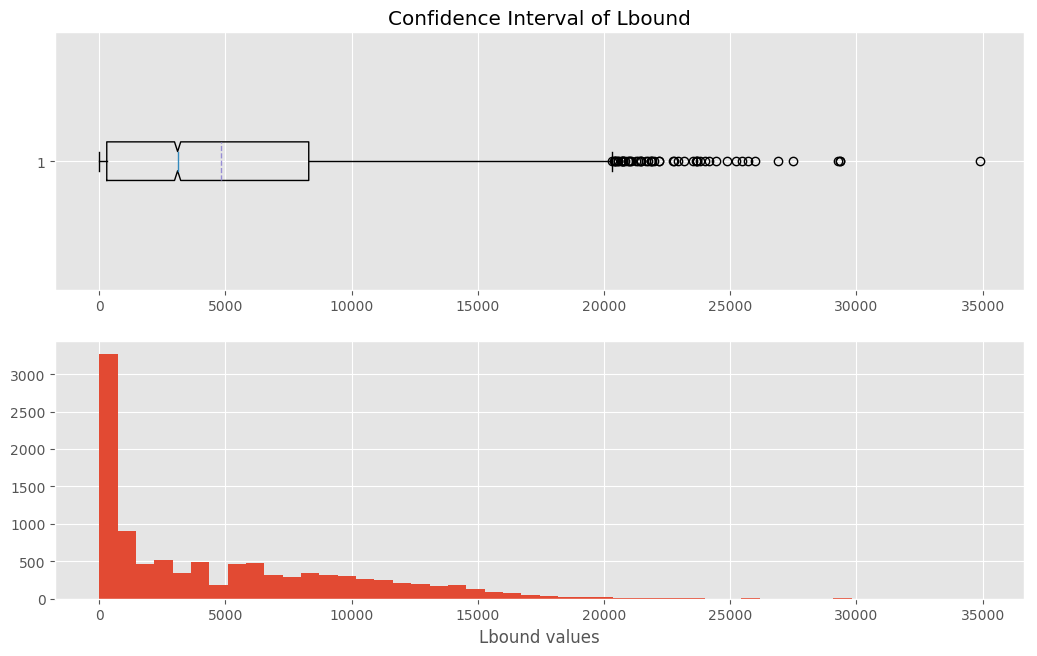

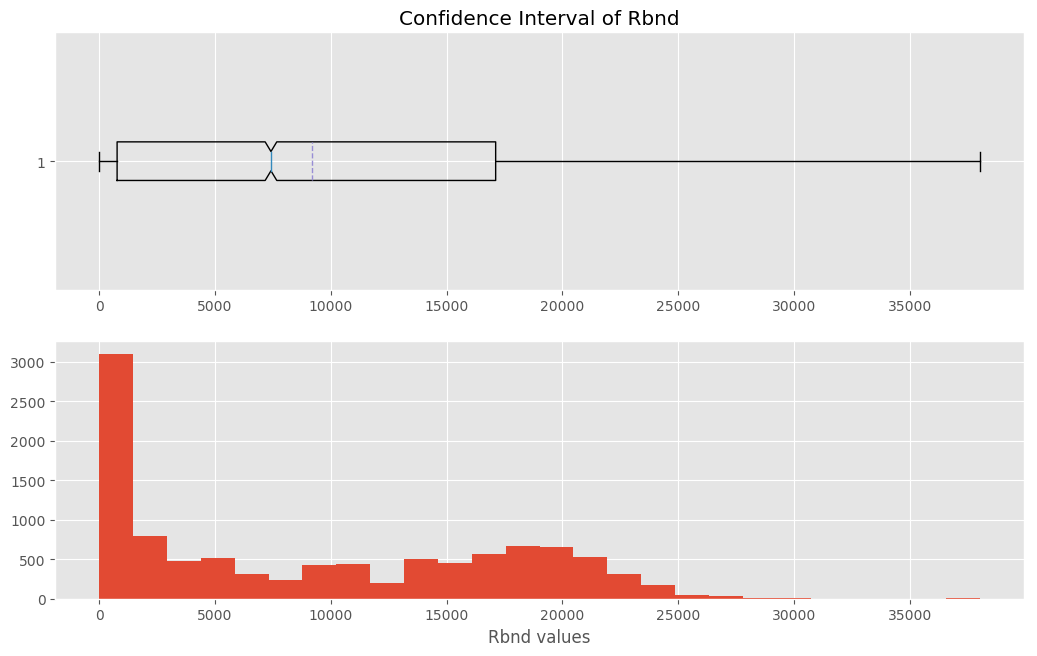

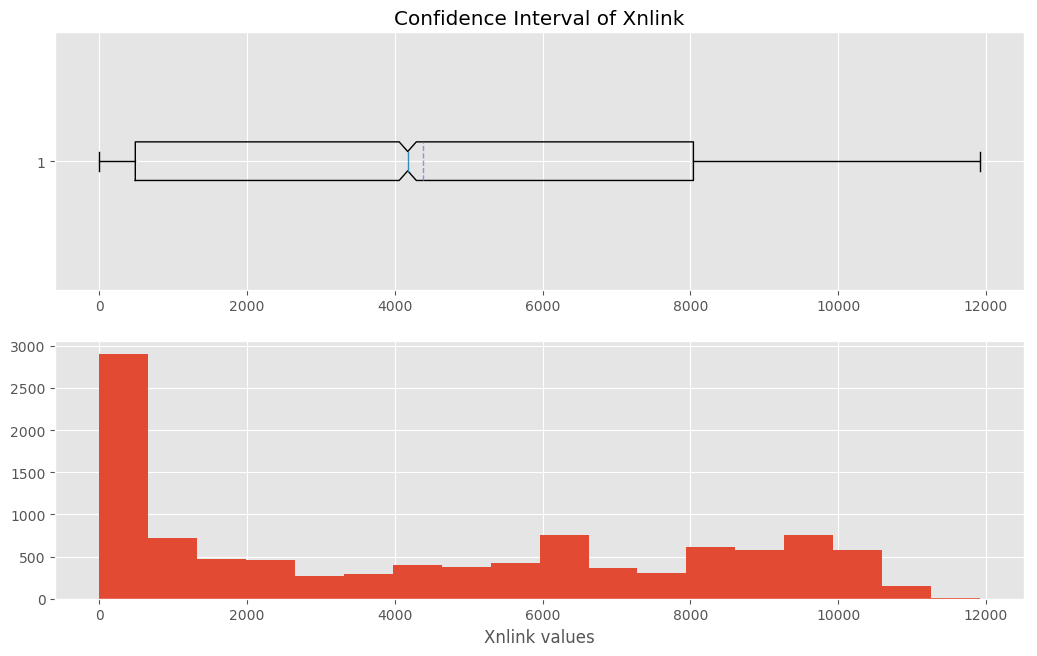

In [31]:
def StoneModScalerLbound(model_parameters, input_values):
    #print('For StoneModScalerRMulti FUNCTION: \nRtot is {},'.format(Rtot)) 
    #print('Kd is {},'.format( model_parameters[0])) 
    #print('v is {},'.format(input_values[0])) 
    #print('Kx is {},'.format(model_parameters[1]))  
    #print('L0 is {},'.format(input_values[1]))  
    #print('scaler is {}.\n'.format(model_parameters[2]))
    return((model_parameters[2]) * StoneMod(Rtot, model_parameters[0], input_values[0], model_parameters[1], input_values[1])[0])

def StoneModScalerRbnd(model_parameters, input_values):
    #print('For StoneModScalerRMulti FUNCTION: \nRtot is {},'.format(Rtot)) 
    #print('Kd is {},'.format( model_parameters[0])) 
    #print('v is {},'.format(input_values[0])) 
    #print('Kx is {},'.format(model_parameters[1]))  
    #print('L0 is {},'.format(input_values[1]))  
    #print('scaler is {}.\n'.format(model_parameters[2]))
    return((model_parameters[2]) * StoneMod(Rtot, model_parameters[0], input_values[0], model_parameters[1], input_values[1])[1])

def StoneModScalernXlink(model_parameters, input_values):
    #print('For StoneModScalerRMulti FUNCTION: \nRtot is {},'.format(Rtot)) 
    #print('Kd is {},'.format( model_parameters[0])) 
    #print('v is {},'.format(input_values[0])) 
    #print('Kx is {},'.format(model_parameters[1]))  
    #print('L0 is {},'.format(input_values[1]))  
    #print('scaler is {}.\n'.format(model_parameters[2]))
    return((model_parameters[2]) * StoneMod(Rtot, model_parameters[0], input_values[0], model_parameters[1], input_values[1])[3])

bs_listsqrY_predicted_holder_R_multi= []
bs_listsqrY_predicted_holder_Lbound = []
bs_listsqrY_predicted_holder_Rbnd = []
bs_listsqrY_predicted_holder_Xnlink = []

for i in range(n_iterations):
    
    train = resample(mergedALL, n_samples = n_size)
    test = [x for x in mergedALL if x not in train]
    bs_X_train, bs_Y_train = zip(*train)
    bs_X_test, bs_Y_test = zip(*test) 
    bs_lstsqr_solution_holder.append(scopt.least_squares(residuals_StoneModScalerRMulti, X0, args=(bs_Y_train, bs_X_train), bounds = (0, 10000)).x)
    
    count = len(bs_X_test)

    
    for j in range(count):
        bs_listsqrY_predicted_holder_R_multi.append(StoneModScalerRMulti(bs_lstsqr_solution_holder[-1], bs_X_test[j]))
        bs_listsqrY_predicted_holder_Lbound.append(StoneModScalerLbound(bs_lstsqr_solution_holder[-1], bs_X_test[j]))
        bs_listsqrY_predicted_holder_Rbnd.append(StoneModScalerRbnd(bs_lstsqr_solution_holder[-1], bs_X_test[j]))
        bs_listsqrY_predicted_holder_Xnlink.append(StoneModScalernXlink(bs_lstsqr_solution_holder[-1], bs_X_test[j]))
        

plt.figure(20, figsize=(12.5, 7.5), dpi=100)

plt.subplot(211)
plt.boxplot(bs_listsqrY_predicted_holder_R_multi, notch=True, showmeans=True, meanline=True, vert=False)
plt.title('Confidence Interval of Rmulti')

plt.subplot(212)
plt.hist(bs_listsqrY_predicted_holder_R_multi, bins='auto')
plt.xlabel("Rmulti values")

plt.show()

plt.figure(21, figsize=(12.5, 7.5), dpi=100)

plt.subplot(211)
plt.boxplot(bs_listsqrY_predicted_holder_Lbound, notch=True, showmeans=True, meanline=True, vert=False)
plt.title('Confidence Interval of Lbound')

plt.subplot(212)
plt.hist(bs_listsqrY_predicted_holder_Lbound, bins='auto')
plt.xlabel("Lbound values")

plt.show()

plt.figure(22, figsize=(12.5, 7.5), dpi=100)

plt.subplot(211)
plt.boxplot(bs_listsqrY_predicted_holder_Rbnd, notch=True, showmeans=True, meanline=True, vert=False)
plt.title('Confidence Interval of Rbnd')

plt.subplot(212)
plt.hist(bs_listsqrY_predicted_holder_Rbnd, bins='auto')
plt.xlabel("Rbnd values")

plt.show()

plt.figure(23, figsize=(12.5, 7.5), dpi=100)

plt.subplot(211)
plt.boxplot(bs_listsqrY_predicted_holder_Xnlink, notch=True, showmeans=True, meanline=True, vert=False)

plt.title('Confidence Interval of Xnlink')

plt.subplot(212)
plt.hist(bs_listsqrY_predicted_holder_Xnlink, bins='auto')
plt.xlabel("Xnlink values")

plt.show()


The above chart shows the range of each of the outputs from StoneMod based on the parameters of Kd, Kx, and the scaler. We know that Rmulti values are between 20000 and 0 (though some values can be negative) and since many of the values do spread out across this range, the confidence interval is wide. After reading the paper, one can see that the definiton of Rmulti, the number of cross linked receptors, must be proportional to Xnlink since that is the number of cross links. We also see that they have approximately the same size of confidence intervals (similar IQR box area).

Lbound is the number of oligomers bound per cell which in a sense is binary, since an oligomer can be bound or not, unlike the other measurements. Predictions of Lbound should be more accurate.

#### (9) Other quantities such as the number of bound receptors may be possible to measure as well. Describe how you would go about fitting this data along with the multimerized receptor measurements. In general, which do you think is better for exactly fitting the model: more measurements of the same type or more measurements of different types?

The process of fitting a model to data to bound receptors along with  would follow the same general pathway as the steps used in this homework. The only different step would be to split (split the y matrix into two separate columns) the model to predict on multimerized receptor measurements and also predict number of bound measurements separately. Then I would visualize the data to get a feel for crude trends that I can use to check my later work or some basic hypotheses about future conclusions.Then I would evaluate the model by performing nonlinear least squares using a function of calculated residuals as an input. NLSQ will try to minimize the residuals based off some seed values that I would have guessed. However, at this point I would probably obtain two different sets of model parameters (one for the solution by fitting on  multimerized receptors and one for the solution by fitting on bound receptor). Since I need to validate my model, I perform cross-validation and since it is not a massive dataset, I can perform LOOCV instead of 5 or 10 fold CV. By now I have a validated model, but I can increase the validity of my model's parameters by bootstraping and obtaining confidence intervals for those parameters. Given those confidence intervals, I'd try to see how sensitive my model is to local changes in those parameters, and ultimatley in collective or global changes to those parameters. In the end, I'd have a good idea about the performance of my model and its tendency for error. The problem with this is that does not explain the covariance between the two Ys (the covariance between multimerized receptors and bound receptors). 

Another way would be to perform multivariate regression. It follows the same process as defined above, but we treat the Y matrix as a whole, as opposed to splitting, and instead of forming a vector (a column of residuals when calculating the error) we form a matrix and minimize the trace.

Another way would be doing what we learned in class with PLSR where we create the following:
$X=TP^T+E \\ Y=UQ^T+F$. This model specifically puts an importance between the covariance between X and Y (regardless of the dimensionality of Y).

In general, it is clear that one should have more measurements of the same type (that is measurements or observations or trials) than measurements of different types (that is increasing the number of variables or degrees of freedom) because as we have shown, increasing the number of observations or samples clearly increases the accuracy of our model (lot of examples from homework 1), especially if we're trying to sample a complicated distribution of values. For example, if we could take an infinite amount of measurements of R_multi for each L0, and valency, we wouldn't need a model at all, since we could just use a look up table of values for each R_multi corresponding to a valency and an L0. Measuring more variables does help us in fitting a model but it also does more in explaining why a model is the way it is (can better describe a model's behavior using correlations and causations), than just taking measures of the same type.

In a compressed sensing or a linear algebra framework, having a lot of columns (more measurements of different types) gives a you a terribly undetermined system, a system where the columns are possibly dependent, not enough space in the measurement space to enforce independence of columns. In a system where there are more rows than columns, you have an over determined system which is not as bad as the previous situation, but still difficult to handle. One can rectify the overdetermined system by simplying trying to analyze the noise in the data, removing certain measurements and fitting the model. In the underdetermined system, one can hope that it is S-sparse and find a solution by minimizing the L0 norm as opposed to the L2 norm, as long as the sparse subset of columns is independent.